## Analysis of the Influence of Campaign Contributions and Incumbency on the Outcome of the 2016 House of Representatives Election Cycle

In [1]:
from warnings import simplefilter
simplefilter(action='ignore')
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns 
plt.style.use('seaborn-v0_8')
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'  
plt.rcParams['font.serif'] = ['Computer Modern']
plt.rcParams['font.size'] = 12
import scienceplots
from sklearn.metrics import *

### Introduction

Although the subject of money in politics has gained increasing media coverage in the wake of the Supreme Court's fateful ruling on Citizens United v. Federal Election Comission in 2010, the national conversation over whether and to what extent campaign finance exerts a corrosive influence on our democracy dates back as far as the 1828 grassroots presidential candidacy of Andrew Jackson, which was the first presidential campaign to organize via specialized campaign offices and to actively solicit donations from individual contributors. Throughout the remainder of our history, this issue has resurfaced periodically as scandal, public outrage, and at least one [assassination](https://en.wikipedia.org/wiki/Spoils_system#Reform) drove legislative [efforts](https://en.wikipedia.org/wiki/Federal_Corrupt_Practices_Act) at [reform](https://en.wikipedia.org/wiki/Tillman_Act_of_1907), the majority of which were ultimately [circumvented](https://issueone.org/articles/corporations-still-playing-politics-century-president-theodore-roosevelt-tillman-act/) or [struck down](https://en.wikipedia.org/wiki/Newberry_v._United_States) by SCOTUS, culminating in Citizens United. Given that cash infusions into federal political campaigns appear to be [increasing](https://www.opensecrets.org/news/2024/10/total-2024-election-spending-projected-to-exceed-previous-record/) with each general election cycle, the question of how money influences election dynamics remains as timely as ever.

This proof-of-concept pilot project originated from an attempt to use elementary statistical techniques in Python to investigate the extent to which campaign contributions recorded by the FEC during the 2015-2016 congressional cycle drove general election outcomes in the House of Representatives. Although ghe subejct of modern campaign finance have been elucidated by data journalism outlets such as [Vox](https://www.vox.com/2014/7/30/5949581/money-in-politics-charts-explain) and [FiveThirtyEight](https://fivethirtyeight.com/features/money-and-elections-a-complicated-love-story/), coverage of the specific question of interest to this project has been covered more superficially and indeterminately by the news media. In particular, this project seeks to explore whether and to what extent total campaign contributions determine election outcome: In short, other things equal, does an arbitrary candidate who receives more money than their opponents generally achieve electoral victory? 

Of course, many candidate attributes other than campaign funds are known drive electoral outcomes. One such characteristic of particular importance to congressional elections is incumbency, which could plausibly confound the research hypothesis that campaign contributions drive election outcomes by the following mechanism: It is conceivable that big money donors, hoping to curry favor with a candidate they expect will remain in the legislature, may contribute more generously to incumbent candidates in anticipation of their likely victory. While this scenario would arguably still lend rhetorical support for the position that money has a corrupting influence on our politics, it would confute our hypothesis by revealing the correlation between campaign contributions and electoral outcome to be spurious. In order to take this possibility into account, the following analysis focuses on both total campaign contributions and incumbency as predictors of electoral victory or defeat.

### Notebook Overview

This notebook contains:
1. A brief [inspection](#Data-Inspection) of the final, processed dataset.
2. Tables, charts, and other visualizations summarizing the data.
3. [Correlation analyses and statistical tests](#Correlation-Analysis-and-Non-Parametric-Comparison-Testing) exploring patterns in the data.
4. [Multiple logistic regression analyses](#Covariate-Adjusted-Logistic-Regression-Analysis) exploring the joint effect of campaign contributions and incumbency with covariate adjustment to assess the effect of contributions after controlling for the effect of incumbency.
5. Assessment of several [machine learning models](#Algorithmic-Classification-and-Electoral-Outcome-Prediction) trained on the data, including evaluation of their predictive performance and visualizations of their decision boundaries.

For more details on project structure, materials, methodology, and results, please refer to this [project's README](https://github.com/neophyte577/campaign-finance-house-2016/blob/main/README.md).

### Data Inspection

The data loaded below were obtained from the United States [Federal Election Comission](https://www.fec.gov/data/browse-data/?tab=bulk-data). They were cleaned and prepared within the notebooks entitled [house_campaign_finance_data_2016_prep](https://github.com/neophyte577/campaign-finance-house-2016/blob/main/data-prep/house_campaign_finance_data_2016_prep.ipynb) and [house_election_results_2016_prep](https://github.com/neophyte577/campaign-finance-house-2016/blob/main/data-prep/house_election_results_2016_prep.ipynb) in the data_prep/ directory of this repository, and were finally merged in [data_synthesis_finance_election_results](https://github.com/neophyte577/campaign-finance-house-2016/blob/main/data_synthesis_finance_election_results.ipynb) to yield the dataset we will ultimately use for our analysis. Please see the linked notebooks for comprehensive discussion of how these data were processed and synthesized.

In [2]:
house = pd.read_csv('../../data/analysis-ready/house-2016-larger-dataset.csv')

In [3]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1385 entries, 0 to 1384
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   fec_id      1385 non-null   object 
 1   state_abbr  1385 non-null   object 
 2   first_name  1385 non-null   object 
 3   last_name   1385 non-null   object 
 4   name        1385 non-null   object 
 5   party       1385 non-null   object 
 6   inc         1385 non-null   object 
 7   tot_rec     1385 non-null   float64
 8   winner      1385 non-null   float64
dtypes: float64(2), object(7)
memory usage: 97.5+ KB


In [4]:
house.head()

,fec_id,state_abbr,first_name,last_name,name,party,inc,tot_rec,winner
0,H6AK00045,AK,donald,young,donald young,Republican,Incumbent,1103561.86,1.0
1,H6AK00235,AK,steve,lindbeck,steve lindbeck,Democrat,Challenger,1102309.77,0.0
2,H6AL01060,AL,larry,young,larry young,Republican,Challenger,178766.88,0.0
3,H6AL02167,AL,nathan,mathis,nathan mathis,Democrat,Challenger,36844.00,0.0
4,H0AL02087,AL,martha,roby,martha roby,Republican,Incumbent,1404260.12,1.0


### Data Dictionary

The final dataset loaded above contains nine columns of which it is presumed the first five are self-explanatory (viz., 'fec_id', 'state_abbr', 'first_name', 'last_name', and 'name', all strings, none of which are used in the displays and analyses which follow, but were preserved for data integrity and diagnostic purposes) and four variables of interest to the remaining sections of this notebook:

1) Total Campaign Receipts ('tot_rec') - float64: Denoted in the [Analysis](#Analysis) section of this notebook as $C$, and alternately referred to synonymously as "total campaign contributions," "contributions," "receipts," and similar variations throughout the remainder of the notebook. A decision was made to incorporate this single variable to the exclusion of all other currency-valued columns in the finance data after a cursory check of the finance data revealed that 'tot_rec' approximately equaled the sum of the majority of the other currency-valued columns, and clearly indicates the total amount of money received by a campaign from all sources for which the FEC mandates reporting. In the interest of parsimony and to prevent overfitting, these redundant columms were omitted from the data for the purposes of the present analysis, although this project leaves ample room to incorporate additional currency-valued features in the generalization to a larger dataset including additional election cycles, to drill down further and explore, e.g., whether campaigns which took out larger loans (n.b. [loans also constitute campaign contributions](https://www.fec.gov/help-candidates-and-committees/candidate-taking-receipts/types-contributions/) according to FEC rules) stood a greater or lesser chance of victory than those who relied more heavily on transfers from committees. However, for the purposes of investigating the more straightforward hypothesis regarding the extent to which campaign contributions drive electoral outcomes, we will postpone consideration of such nuances and focus exclusively on total campaign receipts as a measure of the amount of money infused into a campaign.

2) Incumbency ('inc') - string: Denoted in the [Analysis](#Analysis) section as $I$, this variable encodes the three possible competitive dispositions of the 2016 House candidates, namely 'Incumbent', 'Challenger', and 'Open' seat contender: 
    - 'Incumbent': An **incumbent** is a political candidate who currently holds the position for which they are running.
    - 'Challenger': As the name suggests, a **challenger** is a political candidate who is running against an incumbent and other challengers.
    - 'Open': If an elected office/position is for any reason vacated (e.g., if the previous holder of that office retires or resigns), then the race is considered **open**, and any candidate running for an open seat in the House will hereafter be referred to as an 'open seat contender' or 'open contender.'

    Since it was surmised at the outset that incumbency is a major driver of electoral outcome which may consitute a significant covariate with total campaign contributions (and therefore a potential confounding factor if omitted), it was deemed necessary to include a variable indicating whether a candidate was incumbent or not. Helpfully, the FEC finance data went one step further and also delineated non-incumbents by whether they were challenging an incumbent for their seat or vying for an open seat. As will be seen below, these differences in disposition prove crucial to understanding the role of campaign contributions in determining election outcomes.

3) Political Party Affiliation ('party') - string: Due to the paucity of third party candidates for which the FEC received data for the 2015-2016 House election cycle, candidates were classified according to party affiliation as 'Independent', 'Republican', 'Democrat', or 'Other'. Should subsequent data from other election cycles contain more complete financial records for third party campaigns, it may be of interest to explicitly incorporate, e.g., the Green Party, Libertarian Party, etc. into the analysis.

4) Electoral Outcome ('winner') - string: Denoted in the [Analysis](#Analysis) section as $W$, this is a dichotomous string column encoding electoral victory or loss.


### Data Description and Visualization

#### Descriptive Statistics and Histograms for Total Campaign Contributions

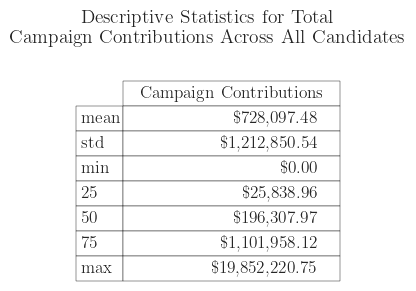

In [5]:
d = house[['tot_rec']].describe().drop(index='count')

d['tot_rec'] = d['tot_rec'].apply(lambda x: f"\${x:,.2f}" if isinstance(x, (int, float)) else x)

d.rename(columns={'tot_rec':'Campaign Contributions'}, inplace=True)

fig, ax = plt.subplots(figsize=(3,3))

ax.axis('tight')
ax.axis('off')

table = ax.table(
    cellText=d.values,
    colLabels=d.columns,
    rowLabels=d.index,
    loc='center',
    cellLoc='right'
)

table.auto_set_font_size(False)
table.set_fontsize(12.5)
table.scale(1, 2)
fig.suptitle('Descriptive Statistics for Total\n Campaign Contributions Across All Candidates', fontsize=14)
fig.tight_layout()
fig.savefig('../../results/larger-dataset/tables/table_of_descriptive_statistics_for_total_campaign_receipts_across_all_candidates.png')
plt.show()

Note the wide range of nearly $\$20$ million, large standard deviation at approximately $1.5$ times the mean, and pronounced right skew in the distribution of total campaign contributions (visually apparent in the histograms below). 

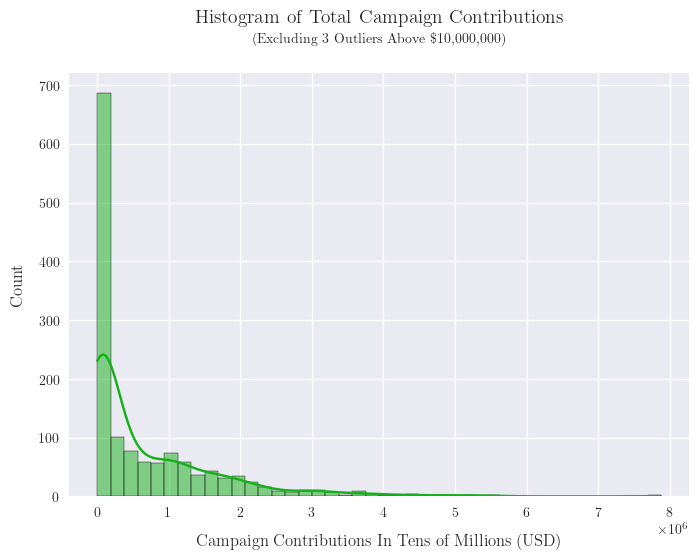

In [6]:
sns.histplot(data=house[house['tot_rec']<10000000], x='tot_rec', kde=True, color='#15b01a') # Exlcude three outliers receiving more than $10,000,000 for legibility

plt.title('Histogram of Total Campaign Contributions\n\\normalsize{(Excluding 3 Outliers Above \$10,000,000)}', fontsize=14, pad=22)
plt.xlabel('Campaign Contributions In Tens of Millions (USD)', labelpad=10, fontsize=12)
plt.ylabel('Count', fontsize=12, labelpad=10)
plt.savefig('../../results/larger-dataset/figures/histogram_of_total_campaign_receipts.png')
plt.show()

Even after excluding the three outliers exceeding $\$10$ million from the data, the extreme skew produces a histogram dominated by smaller observations. In the interest of obtaining a better visual understanding of the distribution, we further restrict the dataset below.

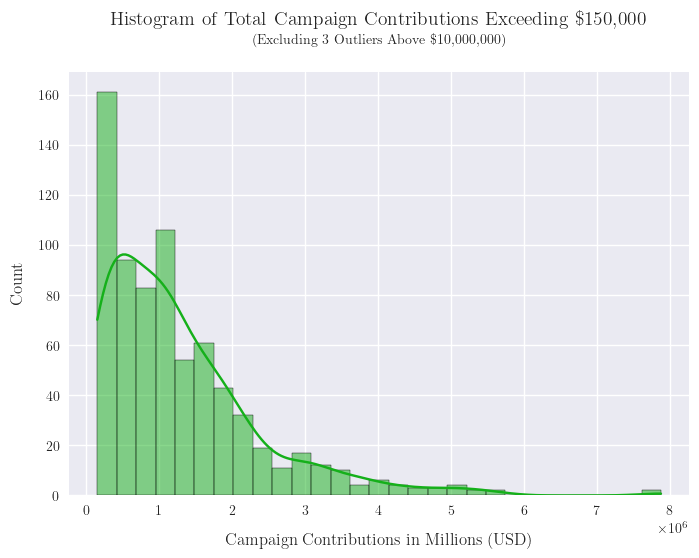

In [7]:
sns.histplot(data=house[house['tot_rec']>150000][house['tot_rec']<10000000], x='tot_rec', kde=True, color='#15b01a') # Exclude candidates receiving less $100,000 and more than $10,000,000

plt.title('Histogram of Total Campaign Contributions Exceeding \$150,000\n\\normalsize{(Excluding 3 Outliers Above \$10,000,000)}', fontsize=14, pad=20)
plt.xlabel('Campaign Contributions in Millions (USD)', labelpad=10, fontsize=12)
plt.ylabel('Count', fontsize=12, labelpad=10)
plt.savefig('../../results/larger-dataset/figures/histogram_of_total_campaign_receipts_exceeding_150000_usd.png')
plt.show()

Restricting the data to include only those candidates who received more than $\$150,000$ in total contributions and less than $\$10$ million reveals an approximate exponential distribution among those candidates who received sufficient contributions to constitute electoral contenders (see below for discussion of the 'threshold effect' whereby candidates who received less than approximately $\$150,000$ may as well not have participated).

#### Total Campaign Contributions by Election Outcome

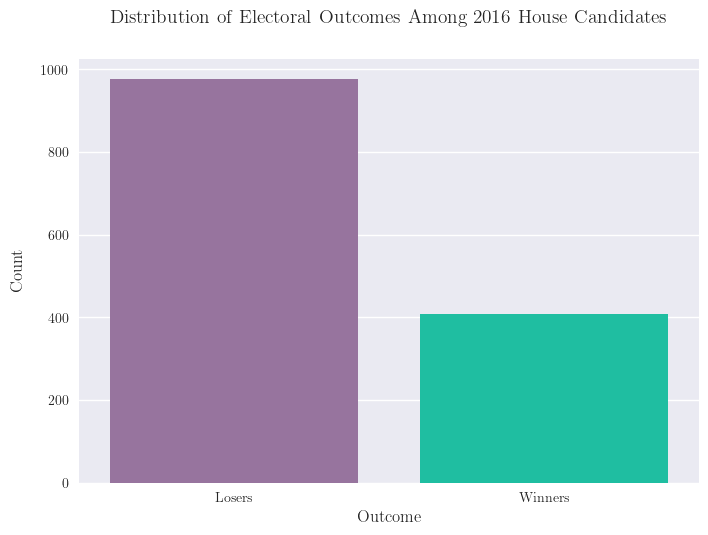

In [8]:
sns.countplot(data=house, x='winner', palette=['#9c6da5','#04d8b2'])

plt.title('Distribution of Electoral Outcomes Among 2016 House Candidates', fontsize=14, pad=26)
plt.xlabel('Outcome', fontsize=12)
plt.ylabel('Count', labelpad=12, fontsize=12)
plt.xticks(ticks=[0,1], labels=['Losers','Winners'])
plt.savefig('../../results/larger-dataset/figures/barplot_of_distribution_of_electoral_outcomes_among_2016_house_candidates.png')
plt.show()

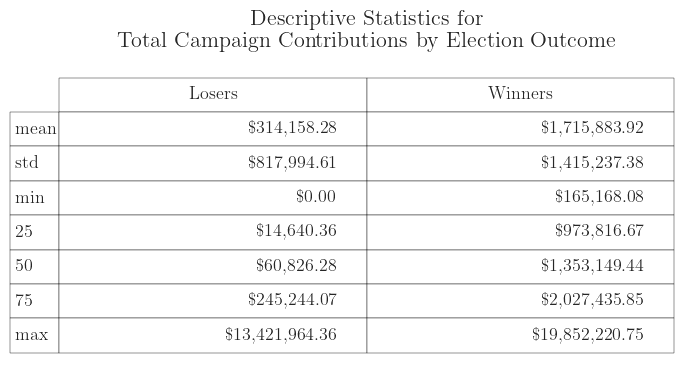

In [9]:
describe_losers = house[house['winner']==0]['tot_rec'].describe().apply(lambda x: f"\${x:,.2f}" 
                                                                        if isinstance(x, (int, float)) else x).drop('count', axis='index')

describe_winners = house[house['winner']==1]['tot_rec'].describe().apply(lambda x: f"\${x:,.2f}" 
                                                                         if isinstance(x, (int, float)) else x).drop('count', axis='index')

des = pd.concat([describe_losers, describe_winners], axis='columns')

fig, ax = plt.subplots(figsize=(7,4))

plt.rcParams['font.family'] = 'Verdana'
ax.axis('off'), ax.axis('tight')
table = ax.table(cellText=des.values.tolist(), rowLabels=des.index, colLabels=['Losers','Winners'], loc='center')
for cell in table.get_celld().values():
    cell.set_fontsize(13)    
table.scale(1,2)
plt.title('Descriptive Statistics for\nTotal Campaign Contributions by Election Outcome', fontsize=16)
fig.tight_layout()
fig.savefig('../../results/larger-dataset/tables/table_of_descriptive_statistics_for_total_campaign_receipts_by_election_outcome.png')
plt.show()

Note the striking difference in quantiles between winners and losers, as well as the contrast between the large minimum among winners and the $\$0.00$ minimum among losers. In particular, we can conclude that no candidate receiving less than $\$165,168.08$ constituted meaningful competition in the 2016 House election, suggesting a 'threshold effect' whereby candidates receiving less than a certain amount in contributions may as well not have participated in the race. The displays below will furnish additional evidence for the impression that electoral winners are concentrated at higher contribution levels.

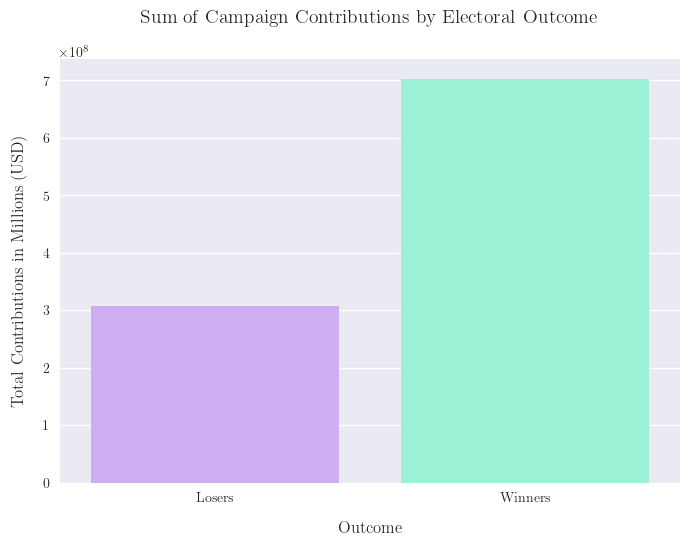

In [10]:
tot_rec_by_outcome = [house[house['winner']==0]['tot_rec'].sum(), house[house['winner']==1]['tot_rec'].sum()]

sns.barplot(x=[0,1], y=tot_rec_by_outcome, palette=['#cea2fd','#8cffdb'])

plt.title('Sum of Campaign Contributions by Electoral Outcome', fontsize=14, pad=26)
plt.xlabel('Outcome', labelpad=12, fontsize=12)
plt.ylabel('Total Contributions in Millions (USD)', labelpad=12, fontsize=12)
plt.xticks(ticks=[0,1], labels=['Losers','Winners'])
plt.savefig('../../results/larger-dataset/figures/barplot_of_sum_of_campaign_contributions_by_electoral_outcome.png')
plt.show()

The foregoing display reveals that electoral winners collectively received over twice as much in total campaign contributions as losers. This absolute difference is large, but somewhat less extreme than one would anticipate on the basis of the foregoing table of Descriptive Statistics for Total Contributions by Election Outcome. The displays which follow suggest that this is attributable to a minority of electoral losers receiving outsized campaign contributions.

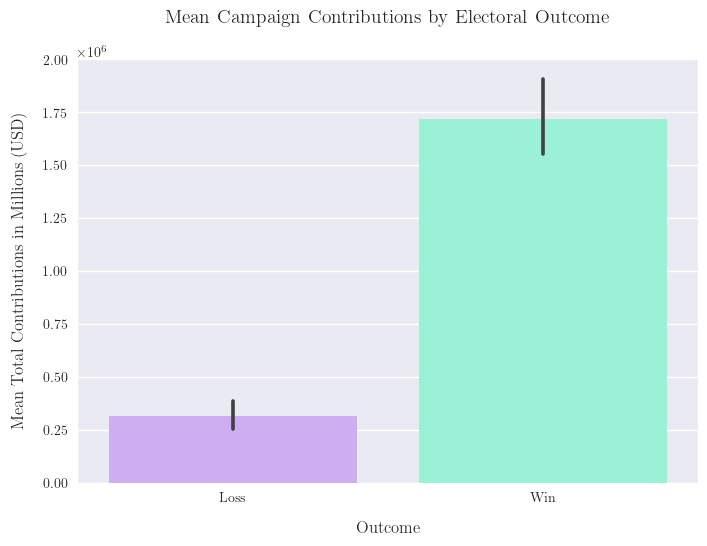

In [11]:
sns.barplot(data=house, x='winner', y='tot_rec', palette=['#cea2fd','#8cffdb'], errorbar=('ci',99))

plt.title('Mean Campaign Contributions by Electoral Outcome', fontsize=14, pad=26)
plt.xlabel('Outcome', labelpad=12, fontsize=12)
plt.ylabel('Mean Total Contributions in Millions (USD)', labelpad=12, fontsize=12)
plt.xticks(ticks=[0,1], labels=['Loss','Win'])
plt.savefig('../../results/larger-dataset/figures/barplot_of_mean_campaign_contributions_by_electoral_outcome.png')
plt.show()

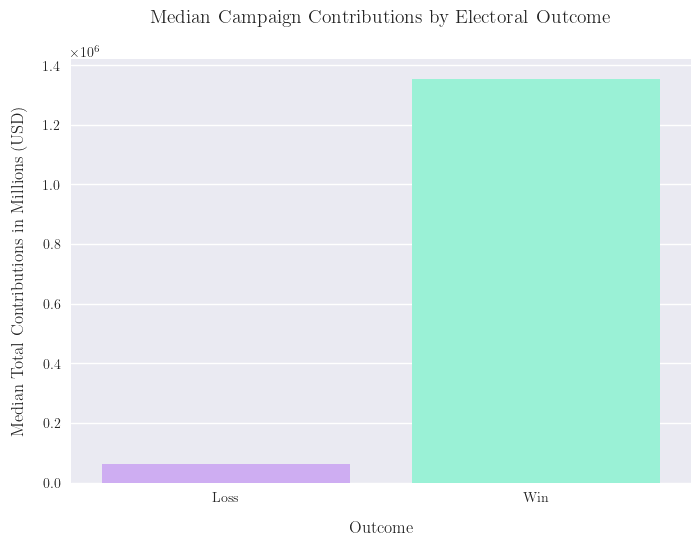

In [12]:
med_rec_by_outcome = [house[house['winner']==0]['tot_rec'].median(), house[house['winner']==1]['tot_rec'].median()]

sns.barplot(data=pd.DataFrame(med_rec_by_outcome), x=[0,1], y=med_rec_by_outcome, palette=['#cea2fd','#8cffdb'], errorbar=None)

plt.title('Median Campaign Contributions by Electoral Outcome', fontsize=14, pad=26)
plt.xlabel('Outcome', labelpad=12, fontsize=12)
plt.ylabel('Median Total Contributions in Millions (USD)', labelpad=12, fontsize=12)
plt.xticks(ticks=[0,1], labels=['Loss','Win'])
plt.savefig('../../results/larger-dataset/figures/barplot_of_median_campaign_contributions_by_electoral_outcome.png')
plt.show()

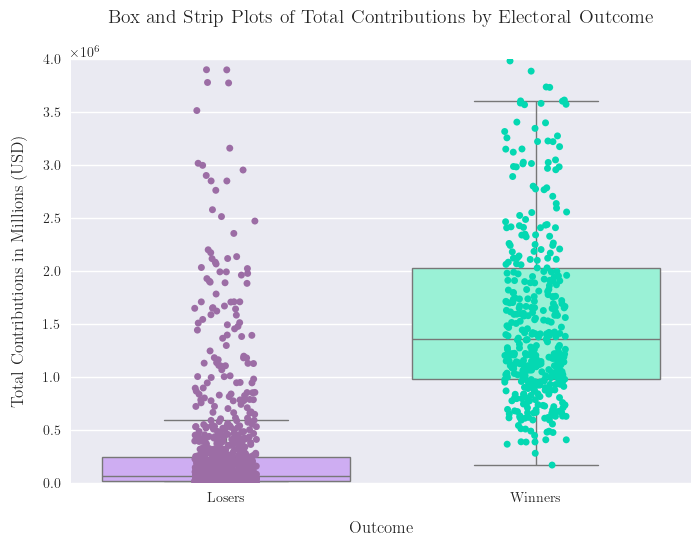

In [13]:
fig, ax = plt.subplots()

# Plot restricted to exclude 18 outliers (constituting approximately 1.3% of the dataset) exceeding $4,000,000 to produce 
# a more informative display
ax.set(ylim=(0, 4000000)) 

ax = sns.boxplot(data=house, x='winner', y='tot_rec', showfliers=False, palette=['#cea2fd','#8cffdb'])

ax = sns.stripplot(data=house, x='winner', y='tot_rec', palette=['#9c6da5','#04d8b2'])

plt.title('Box and Strip Plots of Total Contributions by Electoral Outcome', fontsize=14, pad=26)
plt.xlabel('Outcome', labelpad=12, fontsize=12)
plt.ylabel('Total Contributions in Millions (USD)', labelpad=12, fontsize=12)
plt.xticks(ticks=[0,1], labels=['Losers','Winners'])
plt.savefig('../../results/larger-dataset/figures/box_and_strip_plots_of_total_contributions_by_electoral_outcome.png')
plt.show()

As anticipated above, it appears that a substantial minority of losing candidates (all of which are outliers by virtue of being located above the upper whisker of the Losers boxplot) did indeed receive large contributions comparable to or in excess of typical contributions among winning campaigns. Note also the pronouncd difference in distribution between the two outcomes: The Losers are heavily concentrated at the lower values with most of the dispersion attributable to the aforementioned outliers, whereas the Winners are spread comparatively evenly.

#### Focus on the Two Ruling Parties

In [14]:
duopoly = house.query("party in ['Democrat', 'Republican']")

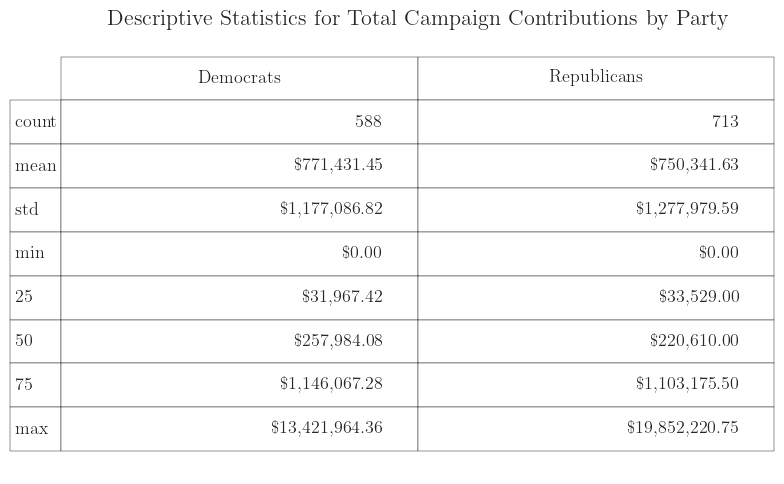

In [15]:
describe_dem = house[house['party']=='Democrat']['tot_rec'].describe().apply(lambda x: f"\${x:,.2f}" if isinstance(x, (int, float)) else x)
describe_dem.loc['count'] = describe_dem.loc['count'].replace('\$','').split('.')[0]

describe_rep = house[house['party']=='Republican']['tot_rec'].describe().apply(lambda x: f"\${x:,.2f}" if isinstance(x, (int, float)) else x)
describe_rep.loc['count'] = describe_rep.loc['count'].replace('\$','').split('.')[0]

des_party = pd.concat([describe_dem, describe_rep], axis='columns')

fig, ax = plt.subplots(figsize=(8, 5))

ax.axis('off'), ax.axis('tight')
table = ax.table(cellText=des_party.values.tolist(),rowLabels=des_party.index,colLabels=['Democrats','Republicans'],
                   loc='center')
for cell in table.get_celld().values():
    cell.set_fontsize(13)   
table.scale(1,2.3)
plt.title('Descriptive Statistics for Total Campaign Contributions by Party', fontsize=16)
fig.tight_layout()
fig.savefig('../../results/larger-dataset/tables/table_of_descriptive_statistics_for_total_received_campaign_funds_by_party.png')
plt.show()

Inspection of the above table reveals that the respective distributions of total campaign contributions among Democrats and Republicans are quite comparable with the exception of the maximum.

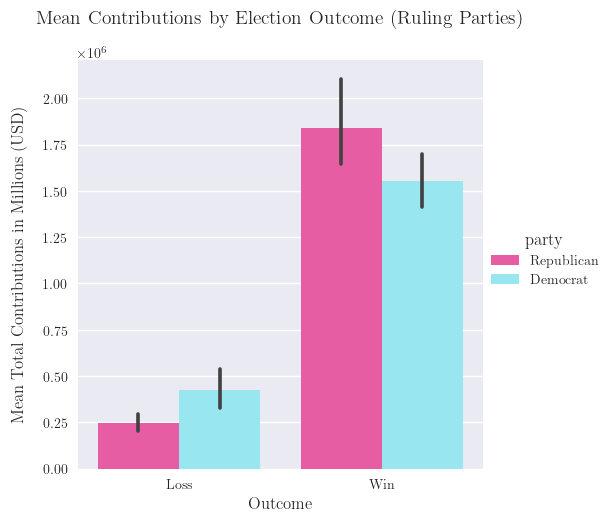

In [16]:
sns.catplot(data=duopoly, kind='bar', x='winner', y='tot_rec', hue='party', hue_order=['Republican','Democrat'], palette=['#fe46a5','#8af1fe'])

plt.title('Mean Contributions by Election Outcome (Ruling Parties)', fontsize=14, pad=26)
plt.xlabel('Outcome', fontsize=12)
plt.ylabel('Mean Total Contributions in Millions (USD)', labelpad=12, fontsize=12)
plt.xticks(ticks=[0,1], labels=['Loss','Win'])
plt.savefig('../../results/larger-dataset/figures/barplot_of_mean_contributions_by_electoral_outcome_ruling_parties.png')
plt.show()

It is interesting to note that the association between outsized campaign contributions and electoral victory is slightly stronger among Republicans than Democrats, although the nearly overlapping error bars indicate this difference may not be statistically significant. 

#### Association of Incumbency with Contributions and Outcome

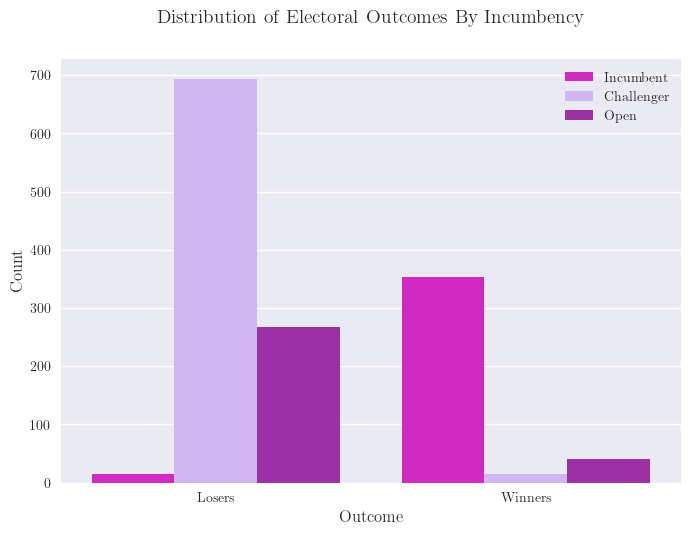

In [17]:
sns.countplot(data=house, x='winner', hue='inc', hue_order=['Incumbent','Challenger','Open'], palette=['#ed0dd9', '#ceaefa', '#ac1db8'])

plt.title('Distribution of Electoral Outcomes By Incumbency', fontsize=14, pad=26)
plt.xlabel('Outcome', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(ticks=[0,1], labels=['Losers','Winners'])
plt.gca().legend().set_title('')
plt.savefig('../../results/larger-dataset/figures/barplot_of_distribution_of_electoral_outcomes_by_incumbency.png')
plt.show()

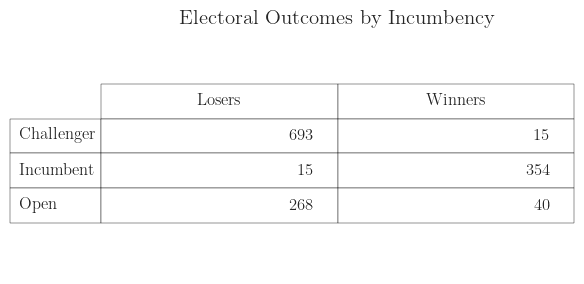

In [18]:
win_by_inc = pd.concat([house[house['winner']==0].groupby('inc')['winner'].count(), 
                       house[house['winner']==1].groupby('inc')['winner'].count()], axis='columns'
)

fig, ax = plt.subplots(figsize=(6, 3))

plt.rcParams['font.family'] = 'Verdana'
ax.axis('off'), ax.axis('tight')
table = ax.table(cellText=win_by_inc.values.tolist(), rowLabels=win_by_inc.index, colLabels=['Losers','Winners'], loc='center')
for cell in table.get_celld().values():
    cell.set_fontsize(12)  
table.scale(1,2)
plt.title('Electoral Outcomes by Incumbency', fontsize=15)
fig.tight_layout()
fig.savefig('../../results/larger-dataset/tables/table_of_electoral_outcome_by_incumbency.png')
plt.show()

As can be seen in the display and table above, incumbents did indeed possess a tremendous advantage over challengers and open seat contenders in the 2016 House race.

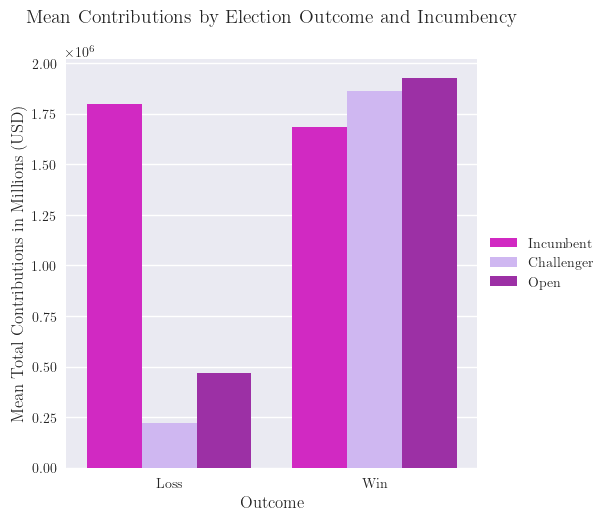

In [19]:
sns.catplot(data=house, kind='bar', x='winner', y='tot_rec', hue='inc', errorbar=None, hue_order=['Incumbent','Challenger','Open'],
            palette=['#ed0dd9', '#ceaefa', '#ac1db8'], legend=False)

plt.title('Mean Contributions by Election Outcome and Incumbency', fontsize=14, pad=26)
plt.xlabel('Outcome', fontsize=12)
plt.ylabel('Mean Total Contributions in Millions (USD)', fontsize=12)
plt.xticks(ticks=[0,1], labels=['Loss','Win'])
plt.legend(title='', labels=['Incumbent','Challenger','Open'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('../../results/larger-dataset/figures/barplot_of_mean_contributions_by_electoral_outcome_and_incumbency.png')
plt.show()

Interestingly, the stark relationship between campaign contributions and electoral outcome holds true for challengers and open contenders, but vanishes (actually, is slightly reversed) for incumbents. However, this could merely imply that, as predicted in the [Introduction](#Introduction), all incumbents tend to receive outsized contributions compared to non-incumbent candidates. The fact that a nonzero fraction of incumbents stands to lose any given election cycle would then suffice to explain the above display.

On the other hand, recall how few challengers and open contenders were represented among the winners and consider that the average contribution to such a candidate can be expected to be quite low compared to the average incumbent. Taken together, this suggests a remarkably strong effect of campaign contributions upon electoral outcome among those candidates for whom there is no possibility of a spurious correlation with incumbency. In other words, based on the above bar chart, our research hypothesis appears quite plausible when applied to non-incumbent candidates.

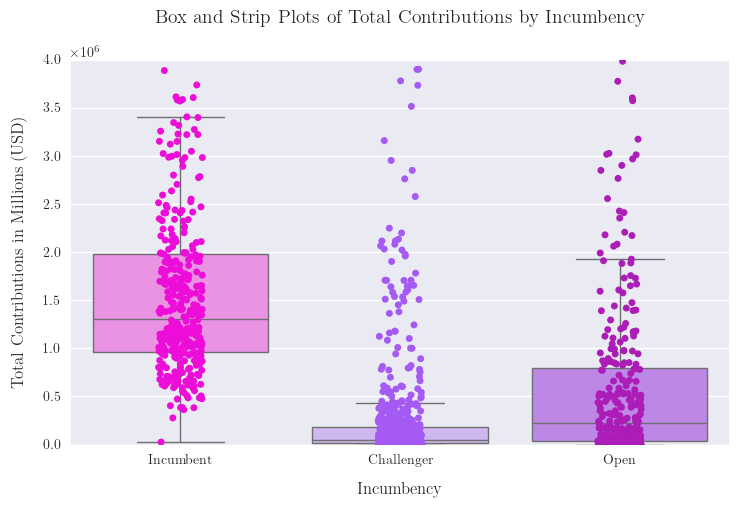

In [20]:
fig, ax = plt.subplots(figsize=(8.5,5))

# Plot restricted to exclude 18 outliers (constituting approximately 1.3% of the dataset) exceeding $4,000,000 to produce 
# a more informative display
ax.set(ylim=(0, 4000000))

ax = sns.boxplot(data=house, x='inc', y='tot_rec', showfliers=False, palette=['#f984ef', '#ceaefa', '#bf77f6'])

ax = sns.stripplot(data=house, x='inc', y='tot_rec', palette=['#ed0dd9', '#a55af4', '#ac1db8'])

plt.title('Box and Strip Plots of Total Contributions by Incumbency', fontsize=14, pad=26)
plt.xlabel('Incumbency', fontsize=12, labelpad=12)
plt.ylabel('Total Contributions in Millions (USD)', fontsize=12, labelpad=12)
plt.xticks(ticks=[0,1,2], labels=['Incumbent','Challenger','Open'])
plt.savefig('../../results/larger-dataset/figures/box_and_strip_plots_of_total_contributions_by_incumbency.png')
plt.show()

As mentioned above, observe the difference in median campaign contributions among the three candidate dispositions, and note the similarity between the distributions of the challengers and open contenders with that of the electoral losers described in the [preceding section](#Total-Campaign-Contributions-by-Election-Outcome). In particular, note that the winners among the challengers and open contenders are vastly likelier to be represented by the outliers located in the extreme upper ranges of their respective distributions based on the foregoing bar chart (Mean Contributions by Election Outcome and Incumbency) and its accompanying remarks.

#### Incumbents

The plot and table below suggest a rather ambiguous relationship between total campaign contributions and electoral outcome among incumbents in particular. Considerable spread in total contributions is exhibited by both losing and winning incumbents, with a (perhaps surprisingly) higher median contributions among losing incumbents. However, this difference is well within the distributions' respective estimated standard deviations of $0.75 \times \text{IQR}$.

Note also the fairly uniform distribution of campaign contributions among the small number of losers as opposed to more skewed distribution of contributions among winners, with the bottom 50% of contributions among winners densely concentrated between about $\$250,000$ and $\$1,250,000$.

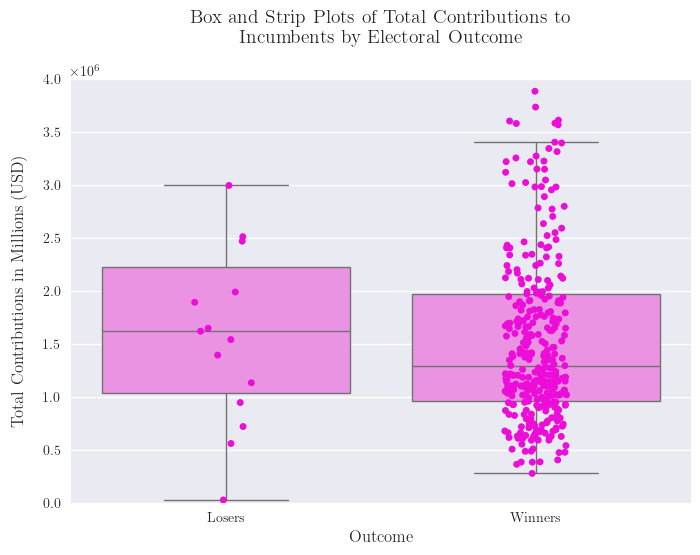

In [21]:
fig, ax = plt.subplots()

# Plot restricted to exclude 18 outliers (constituting approximately 1% of the dataset) exceeding $4,000,000 to produce 
# a more informative display
ax.set(ylim=(0, 4000000))

ax = sns.boxplot(data=house[house['inc']=='Incumbent'], x='winner', y='tot_rec', showfliers=False, palette=['#f984ef'])

ax = sns.stripplot(data=house[house['inc']=='Incumbent'], x='winner', y='tot_rec', palette=['#ed0dd9'])

plt.title('Box and Strip Plots of Total Contributions to\nIncumbents by Electoral Outcome', fontsize=14, pad=26)
plt.xlabel('Outcome', fontsize=12)
plt.ylabel('Total Contributions in Millions (USD)', fontsize=12, labelpad=12)
plt.xticks(ticks=[0,1], labels=['Losers','Winners'])
plt.savefig('../../results/larger-dataset/figures/box_and_strip_plots_of_total_contributions_by_electoral_outcome_incumbents.png')
plt.show()

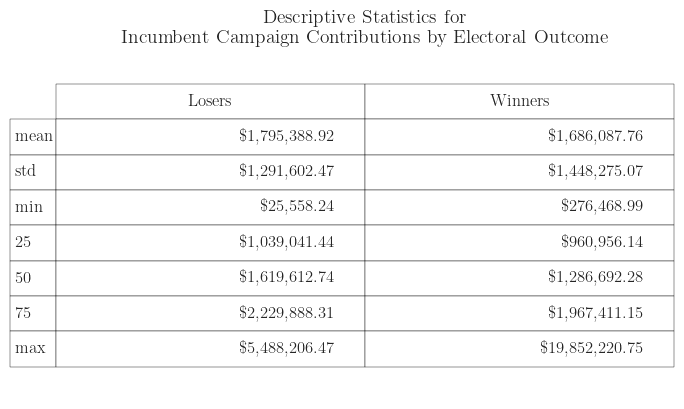

In [22]:
incumbent = house[house['inc']=='Incumbent']

describe_losers = incumbent[incumbent['winner']==0]['tot_rec'].describe().apply(lambda x: f'\${x:,.2f}' if isinstance(x, (int, float)) else x).drop('count', axis='index')

describe_winners = incumbent[incumbent['winner']==1]['tot_rec'].describe().apply(lambda x: f"\${x:,.2f}" if isinstance(x, (int, float)) else x).drop('count', axis='index')

des = pd.concat([describe_losers, describe_winners], axis='columns')

fig, ax = plt.subplots(figsize=(7,4.25))

plt.rcParams['font.family'] = 'Verdana'
ax.axis('off'), ax.axis('tight')
table = ax.table(cellText=des.values.tolist(), rowLabels=des.index, colLabels=['Losers','Winners'], loc='center')
table.scale(1,2)
plt.title('Descriptive Statistics for\nIncumbent Campaign Contributions by Electoral Outcome       ', fontsize=14)
fig.tight_layout()
plt.savefig('../../results/larger-dataset/tables/table_of_descriptive_statistics_for_total_campaign_receipts_by_electoral_outcome_incumbents.png')
plt.show()

#### Challengers

The following plot and table reveal a striking disparity in the distribution of total campaign contributions between winning and losing challengers. In contrast to the above displays, the median Although no relationship is apparent between victory and loss in the upper quantiles, note the dense concentration of losing candidates below about $\$165,000$ in total contributions, with a nearly identical minimum value among winners. This is possibly indicative of a 'threshold effect' whereby non-incumbent candidates receiving less than $\$165,000$ in campaign contributions are at such a disadvantage relative to those who exceeded this threshold that they may as well not have entered the race. On the other hand, the large spread and range of the winners' campaign contributions and the top quintile of the losers' contributions militates against there being a positive linear relationship between total campaign contributions and electoral outcome among challengers.

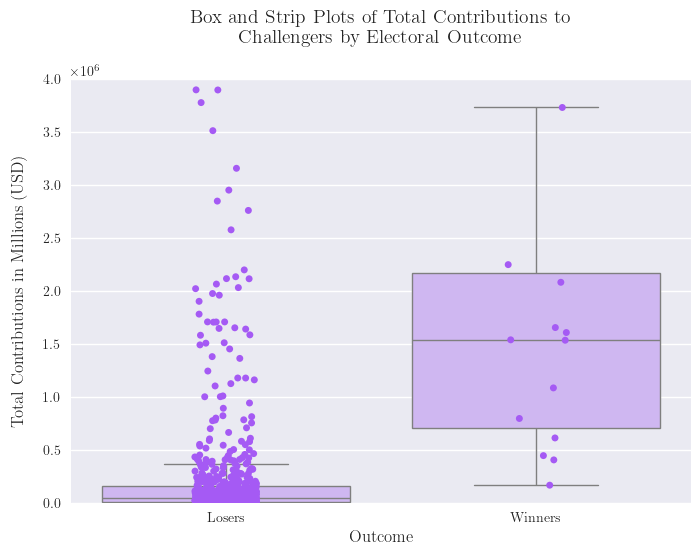

In [23]:
fig, ax = plt.subplots()

# Plot restricted to exclude 18 outliers (constituting approximately 1.3% of the dataset) exceeding $4,000,000 to produce 
# a more informative display
ax.set(ylim=(0, 4000000))

ax = sns.boxplot(data=house[house['inc']=='Challenger'], x='winner', y='tot_rec', showfliers=False, palette=['#ceaefa'])

ax = sns.stripplot(data=house[house['inc']=='Challenger'], x='winner', y='tot_rec', palette=['#a55af4'])

plt.title('Box and Strip Plots of Total Contributions to\nChallengers by Electoral Outcome', fontsize=14, pad=26)
plt.xlabel('Outcome', fontsize=12)
plt.ylabel('Total Contributions in Millions (USD)', fontsize=12, labelpad=12)
plt.xticks(ticks=[0,1], labels=['Losers','Winners'])
plt.savefig('../../results/larger-dataset/figures/box_and_strip_plots_of_total_contributions_by_electoral_outcome_challengers.png')
plt.show()

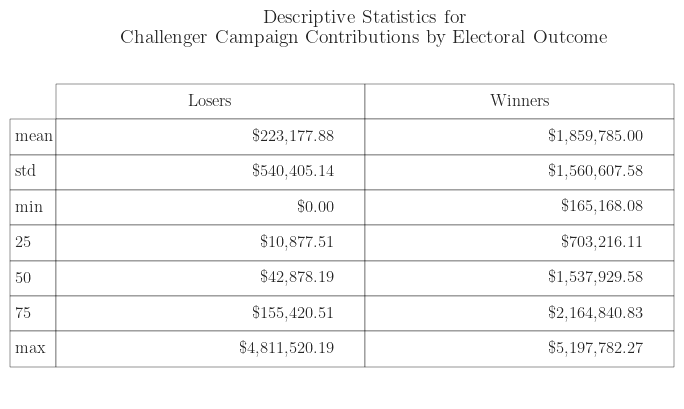

In [24]:
challenger = house[house['inc']=='Challenger']

describe_losers = challenger[challenger['winner']==0]['tot_rec'].describe().apply(lambda x: f'\${x:,.2f}' if isinstance(x, (int, float)) else x).drop('count', axis='index')

describe_winners = challenger[challenger['winner']==1]['tot_rec'].describe().apply(lambda x: f"\${x:,.2f}" if isinstance(x, (int, float)) else x).drop('count', axis='index')

des = pd.concat([describe_losers, describe_winners], axis='columns')

fig, ax = plt.subplots(figsize=(7,4.25))

plt.rcParams['font.family'] = 'Verdana'
ax.axis('off'), ax.axis('tight')
table = ax.table(cellText=des.values.tolist(), rowLabels=des.index, colLabels=['Losers','Winners'], loc='center')
table.scale(1,2)
plt.title('Descriptive Statistics for\nChallenger Campaign Contributions by Electoral Outcome       ', fontsize=14)
fig.tight_layout()
plt.savefig('../../results/larger-dataset/tables/table_of_descriptive_statistics_for_total_campaign_receipts_by_electoral_outcome_challenger.png')
plt.show()

#### Open Seat Contenders

Similar to the foregoing displays, the below plot and table reveal wide range and large dispersion of total campaign contributions among winners and the upper quartile of losers, with a similar density of data points among the losers below the 75th percentile indicating the threshold effect discussed above. 

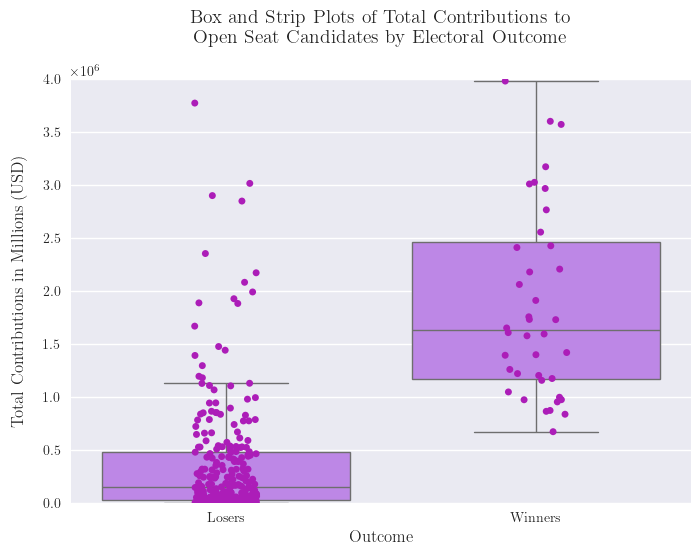

In [25]:
fig, ax = plt.subplots()

# Plot restricted to exclude 18 outliers (constituting approximately 1.3% of the dataset) exceeding $4,000,000 to produce 
# a more informative display
ax.set(ylim=(0, 4000000))

ax = sns.boxplot(data=house[house['inc']=='Open'], x='winner', y='tot_rec', showfliers=False, palette=['#bf77f6'])

ax = sns.stripplot(data=house[house['inc']=='Open'], x='winner', y='tot_rec', palette=['#ac1db8'])

plt.title('Box and Strip Plots of Total Contributions to\nOpen Seat Candidates by Electoral Outcome', pad=26, fontsize=14)
plt.xlabel('Outcome', fontsize=12)
plt.ylabel('Total Contributions in Millions (USD)', fontsize=12, labelpad=12)
plt.xticks(ticks=[0,1], labels=['Losers','Winners'])
plt.savefig('../../results/larger-dataset/figures/box_and_strip_plots_of_total_contributions_by_electoral_outcome_open_contenders.png')
plt.show()

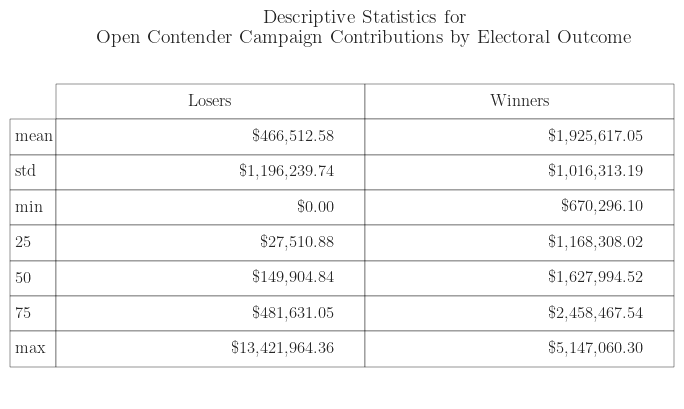

In [26]:
open_ = house[house['inc']=='Open']

describe_losers = open_[open_['winner']==0]['tot_rec'].describe().apply(lambda x: f'\${x:,.2f}' if isinstance(x, (int, float)) else x).drop('count', axis='index')

describe_winners = open_[open_['winner']==1]['tot_rec'].describe().apply(lambda x: f"\${x:,.2f}" if isinstance(x, (int, float)) else x).drop('count', axis='index')

des = pd.concat([describe_losers, describe_winners], axis='columns')

fig, ax = plt.subplots(figsize=(7,4.25))

plt.rcParams['font.family'] = 'Verdana'
ax.axis('off'), ax.axis('tight')
table = ax.table(cellText=des.values.tolist(), rowLabels=des.index, colLabels=['Losers','Winners'], loc='center')
table.scale(1,2)
plt.title('Descriptive Statistics for\nOpen Contender Campaign Contributions by Electoral Outcome       ', fontsize=14)
fig.tight_layout()
plt.savefig('../../results/larger-dataset/tables/table_of_descriptive_statistics_for_total_campaign_receipts_by_electoral_outcome_open_contenders.png')
plt.show()

### Analysis

In [27]:
lose_rec = house[house['winner']==0]['tot_rec']

win_rec = house[house['winner']==1]['tot_rec']

#### Check for Normality

The Q-Q plot and normality tests of total campaign contributions below reflect the extreme right skew evidenced by the tables and histograms produced in the [preceding section](#Data-Description-and-Visualization), indicating significant deviation of total campaign contributions $C$ from normality.

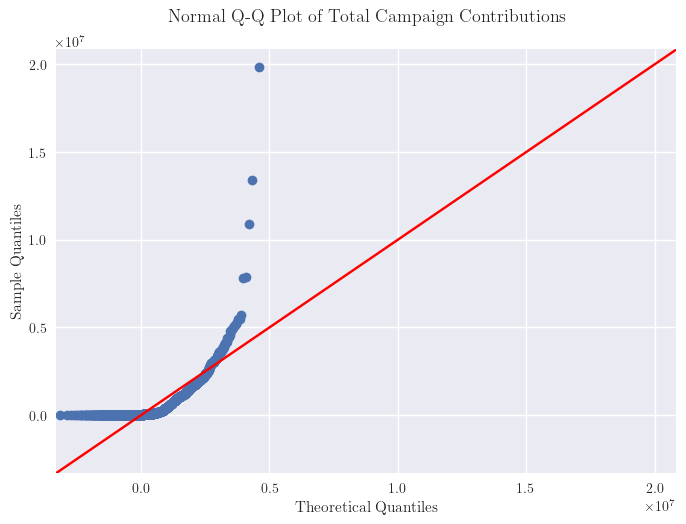

In [28]:
pp = sm.ProbPlot(house['tot_rec'], loc=np.mean(house['tot_rec']), scale=np.std(house['tot_rec']))

ax = pp.qqplot(line='45')

plt.title('Normal Q-Q Plot of Total Campaign Contributions', fontsize=13, pad=20)
plt.show()

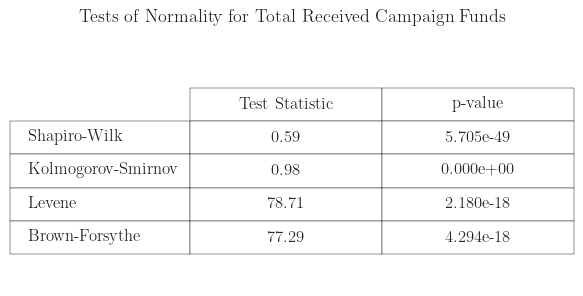

In [29]:
shapiro_wilk = list(map(str, list(stats.shapiro(house['tot_rec']))))

kolmogorov_smirnov = list(map(str, list(stats.kstest(house['tot_rec'], 'norm'))))

levene = list(map(str, list(stats.levene(lose_rec, win_rec, center='mean'))))

brown_forsythe = list(map(str, list(stats.levene(lose_rec, win_rec, center='median'))))

tests = [shapiro_wilk, kolmogorov_smirnov, levene, brown_forsythe] 

test_names = ['Shapiro-Wilk','Kolmogorov-Smirnov', 'Levene','Brown-Forsythe']

test_df = pd.DataFrame(data=tests, index=test_names, columns=['Test Statistic', 'p-value']).astype(float)

test_df['Test Statistic'] = test_df['Test Statistic'].round(2)

test_df['p-value'] = test_df['p-value'].apply(lambda x: f"{x:.3e}")

fig, ax = plt.subplots(figsize=(6, 3))

ax.axis('tight')
ax.axis('off')
plt.rcParams['font.family'] = 'Verdana'

table = ax.table(
    cellText=test_df.values,
    colLabels=test_df.columns,
    rowLabels=test_df.index,
    loc='center',
    cellLoc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 2)
fig.suptitle('Tests of Normality for Total Received Campaign Funds', fontsize=13)
fig.tight_layout()
plt.savefig('../../results/larger-dataset/tables/table_of_normality_tests.png')
plt.show()

### Correlation Analysis and Non-Parametric Comparison Testing

As a supplement to the displays and associated remarks in the [Data Description and Visulization](#Data-Description-and-Visualization) section, a series of correlation coefficients and comparison tests are produced below.

#### Correlations

Unsurprisingly, the correlation between campaign contributions and election outcome passes the threshold of statistical significance, with each of the following three computed coefficient values (all of which exceed $0.5$) indicating a strong relationship.

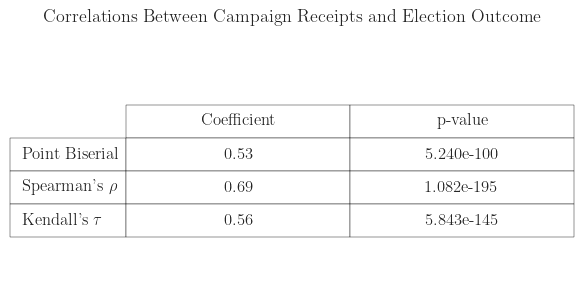

In [30]:
pearson = list(map(str, list(stats.pearsonr(house['tot_rec'],house['winner']))))

spearman = list(map(str, list(stats.spearmanr(house['tot_rec'],house['winner']))))

kendall = list(map(str, list(stats.kendalltau(house['tot_rec'],house['winner']))))

coeffs = [pearson, spearman, kendall]

coeff_names = ["Point Biserial", "Spearman's $\\rho$", "Kendall's $\\tau$"]

coeff_df = pd.DataFrame(data=coeffs, index=coeff_names, columns=['Coefficient', 'p-value']).astype(float)

coeff_df['Coefficient'] = coeff_df['Coefficient'].round(2)

coeff_df['p-value'] = coeff_df['p-value'].apply(lambda x: f"{x:.3e}")

fig, ax = plt.subplots(figsize=(6, 3))

ax.axis('tight')
ax.axis('off')
plt.rcParams['font.family'] = 'Verdana'

table = ax.table(
    cellText=coeff_df.values,
    colLabels=coeff_df.columns,
    rowLabels=coeff_df.index,
    loc='center',
    cellLoc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 2)
fig.suptitle('Correlations Between Campaign Receipts and Election Outcome', fontsize=13)
fig.tight_layout()
plt.savefig('../../results/larger-dataset/tables/table_of_correlation_coefficients.png')
plt.show()

#### Comparison Tests

As can be seen by inspection of the following table, the difference in total campaign contributions between electoral winners and losers achieves statistical significance.

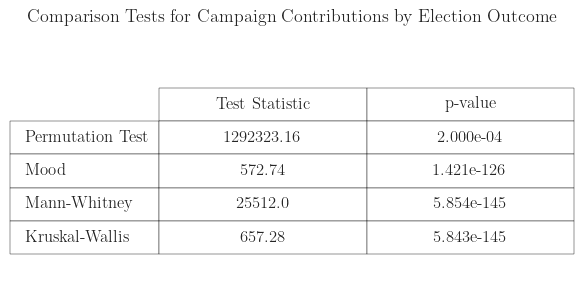

In [31]:
def test_statistic(x, y, axis):
    return np.median(x, axis=axis) - np.median(y, axis=axis)

pt = stats.permutation_test([win_rec, lose_rec], test_statistic)

perm = [pt.statistic, pt.pvalue]

mood = list(map(str, list(stats.median_test(lose_rec, win_rec))))[0:2]

mann_whitney = list(map(str, list(stats.mannwhitneyu(lose_rec, win_rec))))
               
kruskal_wallis = list(map(str, list(stats.kruskal(lose_rec,win_rec))))

tests = [perm, mood, mann_whitney, kruskal_wallis]

test_names = ['Permutation Test', 'Mood', 'Mann-Whitney','Kruskal-Wallis']

test_df = pd.DataFrame(data=tests, index=test_names, columns=['Test Statistic', 'p-value']).astype(float)

test_df['Test Statistic'] = test_df['Test Statistic'].round(2)

test_df['p-value'] = test_df['p-value'].apply(lambda x: f"{x:.3e}")

fig, ax = plt.subplots(figsize=(6, 3))

ax.axis('tight')
ax.axis('off')
plt.rcParams['font.family'] = 'Verdana'

table = ax.table(
    cellText=test_df.values,
    colLabels=test_df.columns,
    rowLabels=test_df.index,
    loc='center',
    cellLoc='center'
)

table.auto_set_font_size(False)
table.scale(1, 2)
fig.suptitle('Comparison Tests for Campaign Contributions by Election Outcome', fontsize=13)
fig.tight_layout()
plt.savefig('../../results/larger-dataset/tables/table_of_comparison_tests.png')
plt.show()

Given the 'threshold effect' discussed [above](#Challengers), it seemed worthwhile to repeat these tests on a trimmed dataset including only those candidates whose total contributions exceeded the minimum of $165,168.08 received by winning campaigns, all of which retained statistical significance.

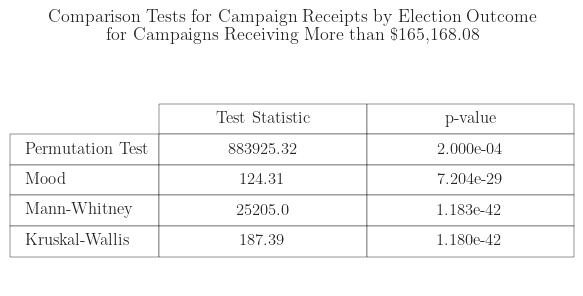

In [32]:
win_rec = win_rec[win_rec>165168.08]
lose_rec = lose_rec[lose_rec>165168.08]

def test_statistic(x, y, axis):
    return np.median(x, axis=axis) - np.median(y, axis=axis)

pt = stats.permutation_test([win_rec, lose_rec], test_statistic)

perm = [pt.statistic, pt.pvalue]

mood = list(map(str, list(stats.median_test(lose_rec, win_rec))))[0:2]

mann_whitney = list(map(str, list(stats.mannwhitneyu(lose_rec, win_rec))))
               
kruskal_wallis = list(map(str, list(stats.kruskal(lose_rec,win_rec))))

tests = [perm, mood, mann_whitney, kruskal_wallis]

test_names = ['Permutation Test', 'Mood', 'Mann-Whitney','Kruskal-Wallis']

test_df = pd.DataFrame(data=tests, index=test_names, columns=['Test Statistic', 'p-value']).astype(float)

test_df['Test Statistic'] = test_df['Test Statistic'].round(2)

test_df['p-value'] = test_df['p-value'].apply(lambda x: f"{x:.3e}")

fig, ax = plt.subplots(figsize=(6, 3))

ax.axis('tight')
ax.axis('off')
plt.rcParams['font.family'] = 'Verdana'

table = ax.table(
    cellText=test_df.values,
    colLabels=test_df.columns,
    rowLabels=test_df.index,
    loc='center',
    cellLoc='center'
)

table.auto_set_font_size(False)
table.scale(1, 2)
fig.suptitle('Comparison Tests for Campaign Receipts by Election Outcome\nfor Campaigns Receiving More than \$165,168.08', fontsize=13)
fig.tight_layout()
plt.savefig('../../results/larger-dataset/tables/table_of_comparison_tests.png')
plt.show()

### Sample Proportions and Tests of Independence

#### Proportion of Wins by Incumbency

In [33]:
h_inc = house[house['inc']=='Incumbent']
h_chal = house[house['inc']=='Challenger']
h_open = house[house['inc']=='Open']

p_inc = round(np.shape(h_inc[h_inc['winner']==1])[0] / np.shape(h_inc)[0], 3)
p_chal = round(np.shape(h_chal[h_chal['winner']==1])[0] / np.shape(h_chal)[0], 3)
p_open = round(np.shape(h_open[h_open['winner']==1])[0] / np.shape(h_open)[0], 3)

print('Proportion of incumbents who won:', p_inc)
print('Proportion of challengers who won:', p_chal)
print('Proportion of open contenders who won:', p_open)

Proportion of incumbents who won: 0.959
Proportion of challengers who won: 0.021
Proportion of open contenders who won: 0.13


#### Proportion of Wins by Incumbency Among Winners

In [34]:

h_inc = house[house['inc']=='Incumbent']
h_chal = house[house['inc']=='Challenger']
h_open = house[house['inc']=='Open']

p_inc = round(np.shape(h_inc[h_inc['winner']==1])[0] / np.shape(house[house['winner']==1])[0], 3)
p_chal = round(np.shape(h_chal[h_chal['winner']==1])[0] / np.shape(house[house['winner']==1])[0], 3)
p_open = round(np.shape(h_open[h_open['winner']==1])[0] / np.shape(house[house['winner']==1])[0], 3)

print('Proportion of incumbents among winners:', p_inc)
print('Proportion of challengers among winners:', p_chal)
print('Proportion of open contenders among winners:', p_open)

Proportion of incumbents among winners: 0.866
Proportion of challengers among winners: 0.037
Proportion of open contenders among winners: 0.098


#### 𝛘² Test of Idependence

Although strong dependence between electoral victory $W$ and incumbency $I$ is readily apparent from inspection of the displays in the preceding section, in the interest of completeness, a 𝛘² test of independence is carried out below.

In [35]:
observed = pd.crosstab(index=house['inc'], columns=house['winner'])

display(observed)

winner,0.0,1.0
inc,,
Challenger,693,15
Incumbent,15,354
Open,268,40


In [36]:
expected = pd.DataFrame(stats.chi2_contingency(observed).expected_freq, index=['Challenger','Incumbent','Open'],
             columns=['Loss','Win']).round().astype(int)

display(expected)

,Loss,Win
Challenger,499,209
Incumbent,260,109
Open,217,91


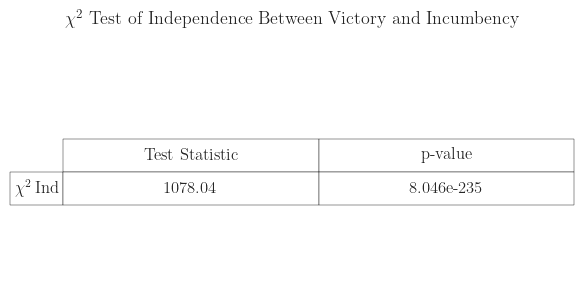

In [37]:
chi2 = list(map(str, [stats.chi2_contingency(observed).statistic, stats.chi2_contingency(observed).pvalue]))

tests = [chi2]

test_names = ["$\\chi^2\\:\\rm{Ind}$"]

test_df = pd.DataFrame(data=tests, index=test_names, columns=['Test Statistic', 'p-value']).astype(float)

test_df['Test Statistic'] = test_df['Test Statistic'].round(2)

test_df['p-value'] = test_df['p-value'].apply(lambda x: f"{x:.3e}")

test_df = pd.DataFrame(data=tests, index=test_names, columns=['Test Statistic', 'p-value']).astype(float)

test_df['Test Statistic'] = test_df['Test Statistic'].round(2)

test_df['p-value'] = test_df['p-value'].apply(lambda x: f"{x:.3e}")

fig, ax = plt.subplots(figsize=(6, 3))

ax.axis('tight')
ax.axis('off')

table = ax.table(
    cellText=test_df.values,
    colLabels=test_df.columns,
    rowLabels=test_df.index,
    loc='center',
    cellLoc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 2)
fig.suptitle('$\\chi^2$ Test of Independence Between Victory and Incumbency', fontsize=13)
fig.tight_layout()
plt.savefig('../../results/larger-dataset/tables/table_chi2_test.png')
plt.show()

### Covariate-Adjusted Logistic Regression Analysis

We now wish to determine the size of the effect of campaign funds in determining electoral outcomes while controlling for the confounding variable of incumbency. As the categorical dependent variable of electoral victory or loss $W$ is not amenable to such an analysis by means of, e.g., one-way ANCOVA, we make use of the Generalized Linear Model (GLM) with logit link

$$\text{logit}(P[W=1]) = \beta_0 + \beta_1 C + \beta_2 I$$

where (as noted above) the dichotomous response variable $W$ denotes electoral victory or loss; the continous explanatory variable $C$ denotes total campaign contributions; and the categorical covariate $I$ denotes incumbency, with $\beta_k$ for $k\in\{0,1,2\}$ denoting the affine model parameters. After fixing dummy variables for $I$ so as to associate $1$

However, as noted during Data Description and Visualization, there exists a substantial imbalance between the binary outcomes of $W$ in this dataset, which could limit the goodness of fit of our model. After a preliminary application of the model to the untrimmed and untransformed data, measures are subsequently taken to address this imbalance, which could introduce bias in our parameter estimates towards the majority response category (the losers).

In [38]:
inc_map = {'Open':0,'Challenger':1, 'Incumbent':2}

print('Winner count of untrimmed data:', np.shape(house[house['winner']==1])[0])
print('Loser count of untrimmed data:', np.shape(house[house['winner']==0])[0])
print('Incumbency counts:\n', house['inc'].value_counts().reindex(['Incumbent', 'Challenger', 'Open'], fill_value=0).rename_axis('') )
print()

X = house[['tot_rec', 'inc']].copy(deep=True)
X['inc'] = X['inc'].map(inc_map)
X['intercept'] = 1

y = house['winner'].copy(deep=True)

model = sm.Logit(y, X) 
result = model.fit(cov_type='HC3')

print(result.summary())
print()

marginal_effects = result.get_margeff()
print(marginal_effects.summary())

Winner count of untrimmed data: 409
Loser count of untrimmed data: 976
Incumbency counts:
 
Incumbent     369
Challenger    708
Open          308
Name: count, dtype: int64

Optimization terminated successfully.
         Current function value: 0.250040
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 winner   No. Observations:                 1385
Model:                          Logit   Df Residuals:                     1382
Method:                           MLE   Df Model:                            2
Date:                Sat, 11 Jan 2025   Pseudo R-squ.:                  0.5880
Time:                        02:09:26   Log-Likelihood:                -346.30
converged:                       True   LL-Null:                       -840.47
Covariance Type:                  HC3   LLR p-value:                2.444e-215
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------

Area under the ROC curve: 0.934


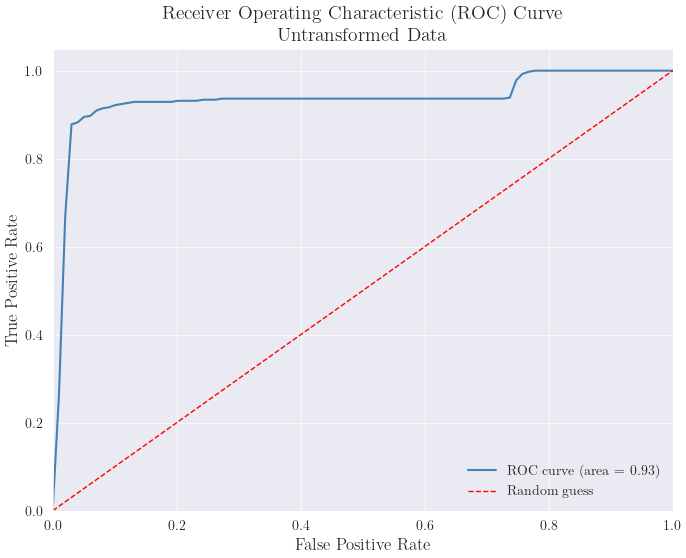

In [39]:
from scipy.interpolate import interp1d

fpr, tpr, thresholds = roc_curve(y, result.predict(X))
roc_auc = auc(fpr, tpr)
print(f'Area under the ROC curve: {roc_auc.round(3)}')

fpr_interp = np.linspace(0, 1, 100)
tpr_interp = interp1d(fpr, tpr, kind='linear')(fpr_interp)

with plt.style.context(['science']):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_interp, tpr_interp, label='ROC curve (area = {:.2f})'.format(roc_auc), color='#4682B4', linewidth=1.5)
    plt.plot([0, 1], [0, 1], label='Random guess', color='red', linestyle='--', linewidth=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.tick_params(axis='both', which='both', length=0)
    plt.title('Receiver Operating Characteristic (ROC) Curve\nUntransformed Data', fontsize=14)
    plt.legend(loc='lower right')
    plt.savefig('../../results/larger-dataset/figures/roc_plot_logistic_regression_untransformed_data.png')
    plt.show()

By virtue of the low LLR and coefficient, $p$-values, solid pseudo-$R^2$ value $R_{\text{McFadden}}^2 = 0.588$ indicative of good model fit, and excellent performance as measured by the area under the ROC curve plotted above, the foregoing analysis reveals strong evidence for rejection of the null hypothesis that total received campaign contributions have no effect on electoral outcome after controlling for incumbency after upsampling winners. In particular, the present analysis yields a conditional odds ratio (OR) for $C$ of 

$$ e^{\beta_1} \approx 1.0000001386.$$

Using the formula

$$\text{Change in Odds} = 1 - \exp(\Delta C \times \beta_1)$$

it is seen that an additional $100,000.00 in campaign contributions multiplies a candidate's odds of victory by 

$$ \exp(\Delta C \times \beta_1) =\exp(100000 \times 0.0000001386) \approx 1.1487$$

i.e., **an additional $100,000.00 in campaign contributions increases a candidate's odds of victory by about 14.87% after controlling for the potentially confounding variable of candidate incumbency**. 

However, it is known that imbalance in the target variable $W$ may vitiate the results of our logistic regression by biasing parameter estimates toward the majority (in this case the losers), decreasing sensitivity, and limiting model fit. In the case of the present dataset, losers outnumber winners by a factor of 2.5 to 1. In order to address this possible limitation, an alternative regression is produced below on an augmented dataset in which additional winners have been introduced using the Synthetic Minority Oversampling Technique (SMOTE).

#### SMOTE

In [40]:
from imblearn.over_sampling import SMOTE

house['inc'] = house['inc'].map(inc_map)

X = house[['tot_rec', 'inc']]
y = house['winner']

smote = SMOTE(random_state=137)
X_smote, y_smote = smote.fit_resample(X, y)

house_smote = pd.DataFrame(X_smote, columns=X.columns)
house_smote['winner'] = y_smote
house_smote['intercept'] = 1

print('Winner count after resampling:', np.shape(house_smote[house_smote['winner']==1])[0])
print('Loser count after resampling:', np.shape(house_smote[house_smote['winner']==0])[0])
house_smote['inc'] = house_smote['inc'].map({v:k for k,v in inc_map.items()})
print('Incumbency counts:\n', house_smote['inc'].value_counts().reindex(['Incumbent', 'Challenger', 'Open'], fill_value=0).rename_axis('') )
house_smote['inc'] = house_smote['inc'].map(inc_map)
print('')
print()

model = sm.Logit(house_smote['winner'], house_smote[['intercept', 'tot_rec', 'inc']]) 
result = model.fit(cov_type='HC3')

print(result.summary())
print()

marginal_effects = result.get_margeff()
print(marginal_effects.summary())

house['inc'] = house['inc'].map({v:k for k,v in inc_map.items()})

Winner count after resampling: 976
Loser count after resampling: 976
Incumbency counts:
 
Incumbent     773
Challenger    798
Open          381
Name: count, dtype: int64


Optimization terminated successfully.
         Current function value: 0.299869
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 winner   No. Observations:                 1952
Model:                          Logit   Df Residuals:                     1949
Method:                           MLE   Df Model:                            2
Date:                Sat, 11 Jan 2025   Pseudo R-squ.:                  0.5674
Time:                        02:09:27   Log-Likelihood:                -585.34
converged:                       True   LL-Null:                       -1353.0
Covariance Type:                  HC3   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------

The low $p$-values and solid pseudo-$R^2$ value $R_{\text{McFadden}}^2 = 0.5674$ indicate similarly good model fit relative to the untransformed case above, again providing strong evidence for rejection of the null hypothesis that total received campaign contributions have no effect on electoral outcome after controlling for incumbency after upsampling winners. In particular, the present analysis yields a conditional odds ratio (OR) for $C$ of 

$$ e^{\beta_1} \approx 1.0000002084,$$

such that an additional $100,000.00 in campaign contributions multiplies a candidate's odds of victory by 

$$\exp(100000 \cdot 0.0000002084) \approx 1.2317$$

i.e., logistic regression on this synthetically oversampled dataset suggests that **an additional $100,000.00 in campaign contributions increases a candidate's odds of victory by about 23.17% after controlling for the potentially confounding variable of candidate incumbency**.

Based on the above, it may be reasonably concluded that the quality of fit obtained above was not severely negatively impacted by the class imbalance in $W$, as the only notable change produced by oversampling is the markedly larger effect size of $C$ noted above as well as an interestingly reduced effect size of $I$. However, given the arguable non-representativeness of the oversampled data of the system we seek to model, as well as the distortive effects of SMOTE on the overall structure of the data (e.g., the SMOTE algorithm generates data points lying on straight lines connecting existing points within the data, which can confer spurious linearity to the oversampled data), caution should be taken in interpreting the above results. On the other hand, future analyses of larger, similarly imbalanced datasets including additional election cycles may benefit more from oversampling than was observed here.

Another potential limitation of logistic regression model fit is multicollinearity of the explanatory variables, explored below in both the untransformed and oversampled context in the form of the Variance Inflation Factor (VIF).

#### Variance Inflation Factor (Untransformed Data)

In [41]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = house[['tot_rec','inc']].copy(deep=True)
X['inc'] = X['inc'].map(inc_map)
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

  Variable       VIF
0  tot_rec  1.510772
1      inc  1.510772


#### Variance Inflation Factor (Upsampled Data)

In [42]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = house_smote.copy(deep=True)
X = X[['tot_rec','inc']]
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

  Variable       VIF
0  tot_rec  1.715168
1      inc  1.715168


As can be seen from the above output, the VIFs associated with $C$ and $I$ are quite low in both the untransformed and oversampled data, indicating low multicollinearity between $C$ and $I$. 

Finally, given the apparent highly skewed relationship between incumbency and campaign receipts (cf. in particular the displays entitled Mean Contributions by Election Outcome and Incumbency, Box and Strip Plots of Total Contributions to Incumbents by Electoral Outcome, and Descriptive Statistics for Incumbent Campaign Receipts by Electoral Outcome in the [data visualization section](#Data-Description-and-Visualization)) and the ambiguous (possibly non-existent) relationship between total campaign receipts and electoral outcome among incumbent candidates in 2016, it seemed reasonable to see whether a more informative model might be obtained by focusing exclusively on challengers and open seat contenders. 

### Focus on Challengers and Open Contenders

The analysis which follows makes use of a modified dataset excluding incumbent candidates and a variant of the above GLM

$$\text{logit}(P[W=1]) = \gamma_0 + \gamma_1 C + \gamma_2 I^*$$

where (as above) the dichotomous response variable $W$ denotes electoral victory or loss; the continous explanatory variable $C$ denotes total campaign contributions; and the categorical covariate $I^*\in \{\text{Challenger},\text{Open}\}$ indicates whether the candidate was a challenger or open seat contender, with $\gamma_k$ for $k\in\{0,1,2\}$ denoting the affine model parameters.

Of course, there were so few winners in this restricted dataset that recourse to SMOTE was deemed necessary to ensure that the new data were sufficiently balanced, despite the abovementioned limitations posed by the SMOTE procedure on the validity and interpretability of results.

In [43]:
house_oc = house[house['inc']!='Incumbent']

house_oc['inc'] = house_oc['inc'].map(inc_map)

X = house_oc[['tot_rec', 'inc']]
y = house_oc['winner']

smote = SMOTE(random_state=137)
X_smote, y_smote = smote.fit_resample(X, y)

house_oc_smote = pd.DataFrame(X_smote, columns=X.columns)
house_oc_smote['winner'] = y_smote
house_oc_smote['intercept'] = 1

print('Winner count after resampling:', np.shape(house_oc_smote[house_oc_smote['winner']==1])[0])
print('Loser count after resampling:', np.shape(house_oc_smote[house_oc_smote['winner']==0])[0])
house_oc_smote['inc'] = house_oc_smote['inc'].map({v:k for k,v in inc_map.items()})
print('Incumbency counts:\n', house_oc_smote['inc'].value_counts().reindex(['Incumbent', 'Challenger', 'Open'], fill_value=0).rename_axis('') )
house_oc_smote['inc'] = house_oc_smote['inc'].map(inc_map)
print('')
print()

model = sm.Logit(house_oc_smote['winner'], house_oc_smote[['intercept','tot_rec', 'inc']]) 
result = model.fit(cov_type='HC3')

print(result.summary())
print()

marginal_effects = result.get_margeff()
print(marginal_effects.summary())

Winner count after resampling: 961
Loser count after resampling: 961
Incumbency counts:
 
Incumbent        0
Challenger     781
Open          1141
Name: count, dtype: int64


Optimization terminated successfully.
         Current function value: 0.312644
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 winner   No. Observations:                 1922
Model:                          Logit   Df Residuals:                     1919
Method:                           MLE   Df Model:                            2
Date:                Sat, 11 Jan 2025   Pseudo R-squ.:                  0.5489
Time:                        02:09:27   Log-Likelihood:                -600.90
converged:                       True   LL-Null:                       -1332.2
Covariance Type:                  HC3   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------

As can be seen in the above display, model fit to the upsampled restricted data as measured by $R_{\text{McFadden}}^2 = 0.5489$ is similar to that of the preceding regressions. Together with the low LLR and coefficient $p$-values, this constitues strong evidence that total campaign receipts are indeed predictive of electoral outcome among challengers and open seat contenders after controlling for $I^*$. The conditional OR for $C$ of 

$$ e^{\gamma_1} \approx 1.000002093,$$

such that an additional $100,000.00 in campaign contributions multiplies a candidate's odds of victory by 

$$\exp(100000 \cdot 0.000002093) \approx 1.233,$$

i.e., logistic regression on the oversampled data suggests that **an additional $100,000.00 in campaign contributions increases a challenger's or open contender's odds of victory by about 23.3% after controlling for any effect of being a challenger or open seat contender**, consistent with the results obtained above.

The slightly inferior model fit obtained relative to the above regressions is likely attributable to the somewhat ambiguous and probably quite weak relationship between $I^*$ and $W$. As can be observed from the displays in the preceding section, winners are massively underrepresented among challengers and open contenders, with only 2.1% of challenger and 13% of open conteders achieving electoral victory in 2016. Given these proportions and the dummy variable assignments of 0 to open contenders and 1 to challengers, it is unsurprising that our multiple logistic regression assigned a negative value to the coefficient $\gamma_2$. On the other hand, the disparity of respresentation of challengers versus open contenders among winners was less extreme, with 3.7% of winners being challengers and 9.8% of winners being open seat contenders.

Moreover, it should be noted that in contrast to the case of incumbent candidates, there is always some degree of arbitrariness of inclusion criteria of challengers and open contenders in any electoral dataset. In particular, note well that such popular candidates as Vermin Supreme, Jesus, and Batman frequently garner nonzero voteshare nationwide, yet are not included in our data, nor, it stands to reason, are innumerable other (possibly more serious) candidates for whom the FEC had no financial data but who did in fact receive nonzero vote share. With this in mind, it seems reasonable to perform a final regression on an undersampled dataset to get a sense for the covariate-controlled impact of $C$ on $W$ after excluding losers as opposed to synthetically oversampling winners. 

In [44]:
from sklearn.utils import resample

house_oc = house[house['inc']!='Incumbent']

house_oc['inc'] = house_oc['inc'].map(inc_map)

house_oc_undersampled = resample(house_oc[house_oc['winner']==0], 
                                   replace=False,   
                                   n_samples=len(house_oc[house_oc['winner']==1]), 
                                   random_state=137)

house_oc_undersampled = pd.concat([house_oc_undersampled, house_oc[house_oc['winner']==1]])

print('Winner count after resampling:', np.shape(house_oc_undersampled[house_oc_undersampled['winner']==1])[0])
print('Loser count after resampling:', np.shape(house_oc_undersampled[house_oc_undersampled['winner']==0])[0])
house_oc_undersampled['inc'] = house_oc_undersampled['inc'].map({v:k for k,v in inc_map.items()})
print('Incumbency counts:\n', house_oc_undersampled['inc'].value_counts().reindex(['Incumbent', 'Challenger', 'Open'], fill_value=0).rename_axis('') )
house_oc_undersampled['inc'] = house_oc_undersampled['inc'].map(inc_map)
print('')
print()

house_oc_undersampled['intercept'] = 1

display(house_oc_undersampled.isna().sum())

X = house_oc_undersampled[['intercept','tot_rec', 'inc']]
y = house_oc_undersampled['winner']

model = sm.Logit(y, X) 
result = model.fit(cov_type='HC3')

print(result.summary())
print()

marginal_effects = result.get_margeff()
print(marginal_effects.summary())

Winner count after resampling: 55
Loser count after resampling: 55
Incumbency counts:
 
Incumbent      0
Challenger    56
Open          54
Name: count, dtype: int64




fec_id        0
state_abbr    0
first_name    0
last_name     0
name          0
party         0
inc           0
tot_rec       0
winner        0
intercept     0
dtype: int64

Optimization terminated successfully.
         Current function value: 0.248108
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                 winner   No. Observations:                  110
Model:                          Logit   Df Residuals:                      107
Method:                           MLE   Df Model:                            2
Date:                Sat, 11 Jan 2025   Pseudo R-squ.:                  0.6421
Time:                        02:09:27   Log-Likelihood:                -27.292
converged:                       True   LL-Null:                       -76.246
Covariance Type:                  HC3   LLR p-value:                 5.488e-22
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.5942      0.937     -2.770      0.006      -4.430      -0.758
tot_rec     3.878e-06   1.11e

Area under the ROC curve: 0.965


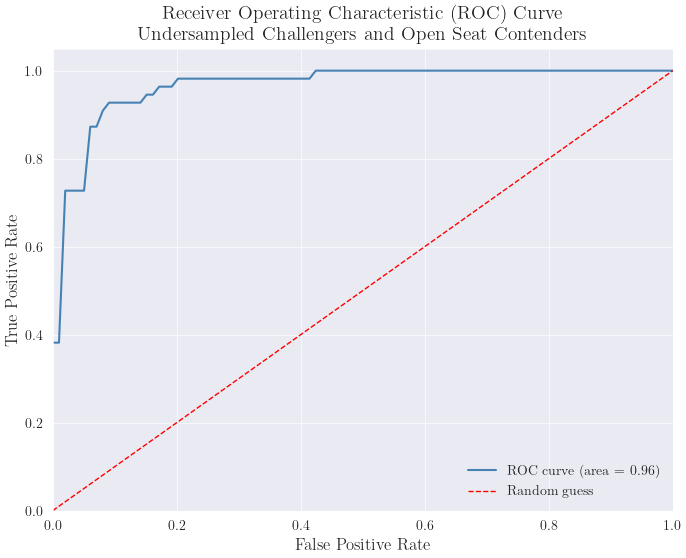

In [45]:
from scipy.interpolate import interp1d

fpr, tpr, thresholds = roc_curve(y, result.predict(X))
roc_auc = auc(fpr, tpr)
print(f'Area under the ROC curve: {roc_auc.round(3)}')

fpr_interp = np.linspace(0, 1, 100)
tpr_interp = interp1d(fpr, tpr, kind='linear')(fpr_interp)

with plt.style.context(['science']):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_interp, tpr_interp, label='ROC curve (area = {:.2f})'.format(roc_auc), color='#4682B4', linewidth=1.5)
    plt.plot([0, 1], [0, 1], label='Random guess', color='red', linestyle='--', linewidth=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.tick_params(axis='both', which='both', length=0)
    plt.title('Receiver Operating Characteristic (ROC) Curve\nUndersampled Challengers and Open Seat Contenders', fontsize=14)
    plt.legend(loc='lower right')
    plt.savefig('../../results/larger-dataset/figures/roc_plot_logistic_regression_open_contenders_and_challengers_undersampled.png')
    plt.show()  

#### Summary

Taken together, the above tests and regression models provide strong evidence in favor of the research hypothesis that campaign contributions $C$ are predictive of electoral victory or defeat $W$, both as such and after controlling for the covariate of incumbency $I$, although as noted in the previous section, the three variables $C$, $I$, and $W$ exhibit subtler relationships than could be captured by the foregoing regressions.

In light of the abovementioned limitations inherent in the application of a multiple logistic regression model to a dataset with an imbalanced response variable, some non-linearity, and a preponderance of outliers in a continuous explanatory variable, it was determined that additional insight might be obtained by training and testing several more sophisticated machine learning models on the data, the majority of which require fewer or no such assumptions.

### Assessment of Linear Separability with Single-Layer Perceptron

Application of a single-layer perceptron to the untransformed data indicated low linear separability which was substantially ameliorated by application of both MinMaxScaler and RobustScaler.

#### Untransformed Data

In [46]:
from sklearn.linear_model import Perceptron

perceptron = Perceptron(random_state=137)

X = house[['inc','tot_rec']]

X = pd.get_dummies(X)

y = house['winner'].astype(int)

perceptron.fit(X, y)

Perceptron(random_state=137)

              precision    recall  f1-score   support

           0       1.00      0.70      0.83      1385
           1       0.00      0.00      0.00         0

    accuracy                           0.70      1385
   macro avg       0.50      0.35      0.41      1385
weighted avg       1.00      0.70      0.83      1385



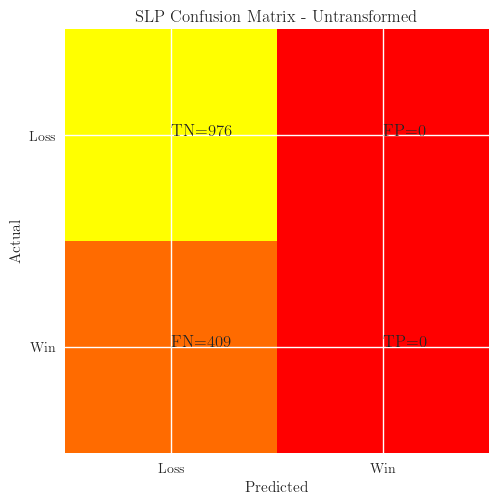

In [47]:
matrix = confusion_matrix(y, perceptron.predict(X))
 
plt.clf() 
plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.autumn)

plt.title('SLP Confusion Matrix - Untransformed')
plt.ylabel('Actual')
plt.xlabel('Predicted')

target = ['Loss','Win']
ticks = [0,1]
plt.xticks(ticks, target)
plt.yticks(ticks, target)

labels = [['TN','FP'], ['FN', 'TP']]
  
for j in range(2):
    for k in range(2):
        plt.text(k,j, str(labels[j][k]) + '=' + str(matrix[j][k]))
        
print(classification_report(perceptron.predict(X), y))
plt.show()

#### Rescaled Data - MinMaxScaler

              precision    recall  f1-score   support

           0       0.98      0.95      0.96      1000
           1       0.88      0.94      0.91       385

    accuracy                           0.95      1385
   macro avg       0.93      0.94      0.94      1385
weighted avg       0.95      0.95      0.95      1385



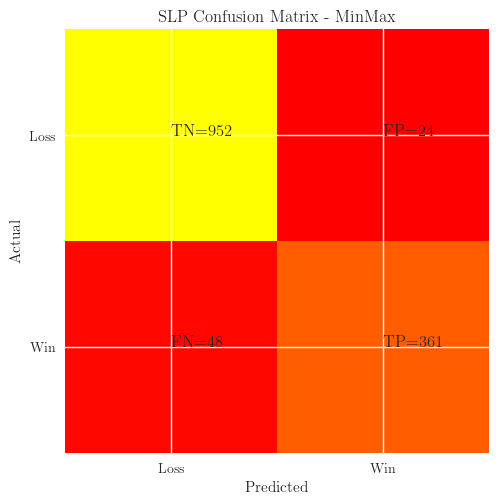

In [48]:
from sklearn.preprocessing import MinMaxScaler

minmax = MinMaxScaler()

X_mm = minmax.fit_transform(X)

perceptron.fit(X_mm, y)

matrix = confusion_matrix(y, perceptron.predict(X_mm))

plt.clf() 
plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.autumn)

plt.title('SLP Confusion Matrix - MinMax')
plt.ylabel('Actual')
plt.xlabel('Predicted')

target = ['Loss','Win']
ticks = [0,1]
plt.xticks(ticks, target)
plt.yticks(ticks, target)

labels = [['TN','FP'], ['FN', 'TP']]
  
for j in range(2):
    for k in range(2):
        plt.text(k,j, str(labels[j][k]) + '=' + str(matrix[j][k]))

print(classification_report(perceptron.predict(X_mm), y))
plt.show()

#### RobustScaler

              precision    recall  f1-score   support

           0       0.98      0.95      0.96      1014
           1       0.87      0.95      0.91       371

    accuracy                           0.95      1385
   macro avg       0.92      0.95      0.94      1385
weighted avg       0.95      0.95      0.95      1385



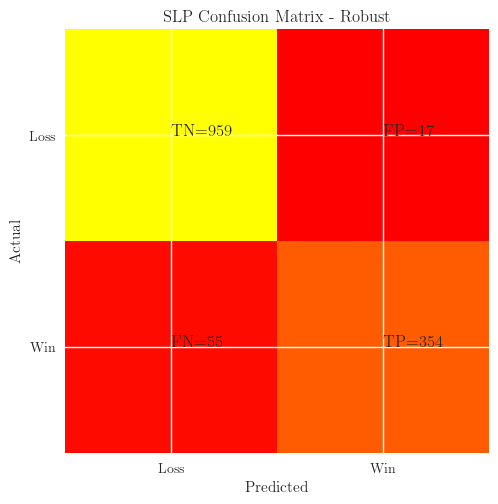

In [49]:
from sklearn.preprocessing import RobustScaler

robust = RobustScaler()

X_rs = robust.fit_transform(X)

perceptron.fit(X_rs, y)

matrix = confusion_matrix(y, perceptron.predict(X_rs))

plt.clf() 
plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.autumn)

plt.title('SLP Confusion Matrix - Robust')
plt.ylabel('Actual')
plt.xlabel('Predicted')

target = ['Loss','Win']
ticks = [0,1]
plt.xticks(ticks, target)
plt.yticks(ticks, target)

labels = [['TN','FP'], ['FN', 'TP']]
  
for j in range(2):
    for k in range(2):
        plt.text(k,j, str(labels[j][k]) + '=' + str(matrix[j][k]))

print(classification_report(perceptron.predict(X_rs), y))
plt.show()

### Algorithmic Classification and Electoral Outcome Prediction

In [50]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

In [51]:
def optimizer(algorithm, param_grid, X, y):
    
    alg = algorithm
    
    gs = GridSearchCV(algorithm, param_grid).fit(X, y)
    
    alg_opt = alg.set_params(**gs.best_params_)
    
    return alg_opt

#### Preprocessing

In [52]:
from sklearn.model_selection import train_test_split

X = house[['inc','tot_rec']]

X = pd.get_dummies(X)

y = house['winner'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=137)

minmax = MinMaxScaler()

X_train_mm = minmax.fit_transform(X_train)

X_test_mm = minmax.transform(X_test)

#### Logistic Regression

In [53]:
log_grid =  {'C':[0.001,0.01,0.1,1,5,7.5,10], 'class_weight':[None,'balanced'], 'penalty':['l1','l2']}

logreg = optimizer(LogisticRegression(), log_grid, X_train_mm, y_train)

logreg.fit(X_train_mm, y_train)

print(logreg.coef_, logreg.intercept_)

[[ 9.86885362 -2.72299963  3.36880022 -1.20029969]] [-0.61498995]


In [54]:
print(classification_report(logreg.predict(X_test_mm), y_test))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97       310
           1       0.89      0.97      0.93       106

    accuracy                           0.96       416
   macro avg       0.94      0.96      0.95       416
weighted avg       0.96      0.96      0.96       416



Text(0.5, 1.0, 'Logistic Regression Confusion Matrix')

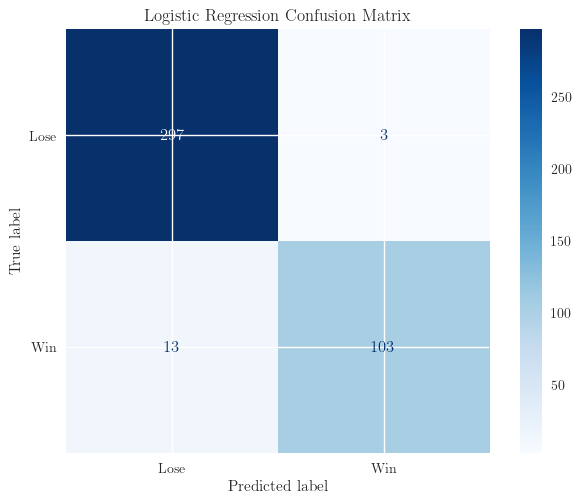

In [55]:
cm_logreg = confusion_matrix(y_test, logreg.predict(X_test_mm), labels=logreg.classes_)

ConfusionMatrixDisplay(confusion_matrix=cm_logreg, display_labels=['Lose','Win']).plot(cmap=plt.cm.Blues)

plt.title('Logistic Regression Confusion Matrix')

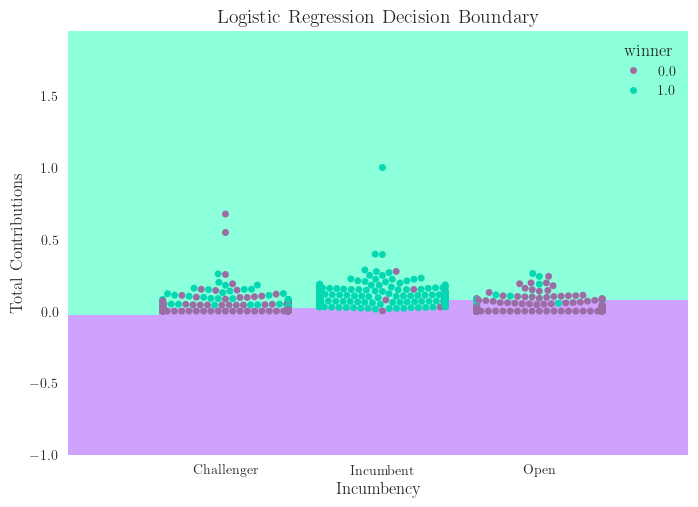

In [56]:
from matplotlib.colors import ListedColormap

H = house.copy(deep=True)

H['inc'] = H['inc'].map({'Incumbent':1,'Challenger':2,'Open':0})

H['tot_rec'] = ( H['tot_rec'] - min(H['tot_rec']) ) / ( max(H['tot_rec']) - min(H['tot_rec']) )

X = H[['inc','tot_rec']]

y = H['winner']

h = .05  

cmap_light = ListedColormap(['#cea2fd','#8cffdb'])
cmap_bold = ListedColormap(['#9c6da5','#04d8b2'])

clf = LogisticRegression(C=5, class_weight='balanced', penalty='l2')
clf.fit(X, y)

x_min, x_max = X['inc'].min() - 1, X['inc'].max() + 1
y_min, y_max = X['tot_rec'].min() - 1, X['tot_rec'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

sns.swarmplot(data=H, x='inc', y='tot_rec', hue='winner', palette=['#9c6da5','#04d8b2'])
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title('Logistic Regression Decision Boundary', fontsize=14)
plt.xticks(ticks=[0,1,2], labels=['Challenger','Incumbent','Open'])
plt.xlabel('Incumbency', fontsize=12)
plt.ylabel('Total Contributions', fontsize=12)
plt.savefig('../../results/larger-dataset/figures/logistic_regression_decision_boundary.png')
plt.show()

#### K-Nearest Neighbor

In [57]:
knn_grid = {'n_neighbors':range(1,100)}

knn = optimizer(KNeighborsClassifier(), knn_grid, X_train_mm, y_train)

knn.fit(X_train_mm, y_train)

KNeighborsClassifier(n_neighbors=9)

In [58]:
print(classification_report(y_test, knn.predict(X_test_mm)))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       300
           1       0.93      0.90      0.91       116

    accuracy                           0.95       416
   macro avg       0.94      0.93      0.94       416
weighted avg       0.95      0.95      0.95       416



Text(0.5, 1.0, 'k-NN Confusion Matrix')

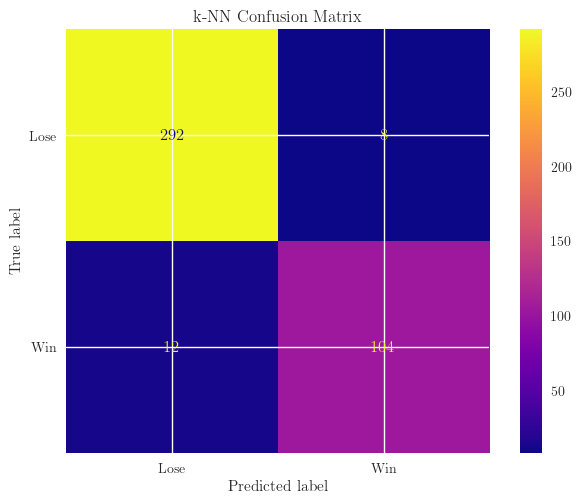

In [59]:
cm_knn = confusion_matrix(y_test, knn.predict(X_test_mm), labels=knn.classes_)

ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=['Lose','Win']).plot(cmap=plt.cm.plasma)

plt.title('k-NN Confusion Matrix')

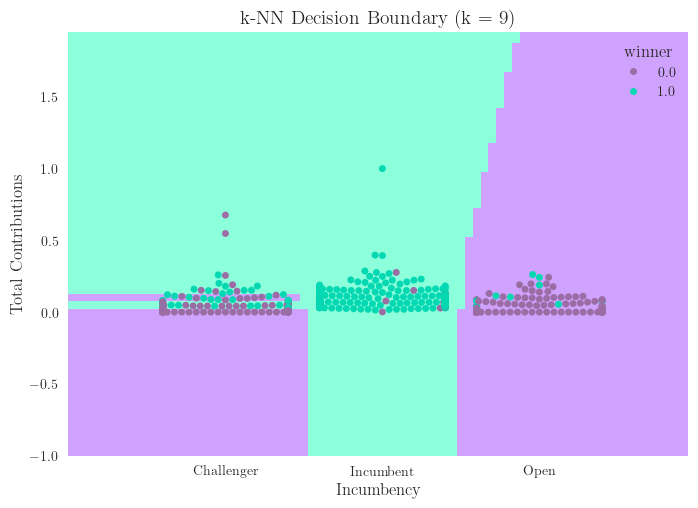

In [60]:
H = house.copy(deep=True)

H['inc'] = H['inc'].map({'Incumbent':1,'Challenger':2,'Open':0})

H['tot_rec'] = ( H['tot_rec'] - min(H['tot_rec']) ) / ( max(H['tot_rec']) - min(H['tot_rec']) )

X = H[['inc','tot_rec']]

y = H['winner']

opt_k = knn.get_params()['n_neighbors']

h = .05  

cmap_light = ListedColormap(['#cea2fd','#8cffdb'])
cmap_bold = ListedColormap(['#9c6da5','#04d8b2'])

clf = KNeighborsClassifier(n_neighbors=opt_k)
clf.fit(X, y)

x_min, x_max = X['inc'].min() - 1, X['inc'].max() + 1
y_min, y_max = X['tot_rec'].min() - 1, X['tot_rec'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

sns.swarmplot(data=H, x='inc', y='tot_rec', hue='winner', palette=['#9c6da5','#04d8b2'])
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("k-NN Decision Boundary (k = {})".format(str(opt_k)), fontsize=14)
plt.xticks(ticks=[0,1,2], labels=['Challenger','Incumbent','Open'])
plt.xlabel('Incumbency', fontsize=12)
plt.ylabel('Total Contributions', fontsize=12)
plt.savefig('../../results/larger-dataset/figures/knn_decision_boundary.png')
plt.show()

#### Support Vector Machine

In [61]:
svc_grid = {'C':[0.01,0.1,0.25,0.5,0.75,1], 'kernel':['libear','rbf', 'sigmoid'],
            'gamma':['scale','auto']}

svc = optimizer(SVC(), svc_grid, X_train_mm, y_train)

svc.fit(X_train_mm, y_train)

SVC(C=0.01)

In [62]:
print(classification_report(svc.predict(X_test_mm), y_test))

              precision    recall  f1-score   support

           0       0.99      0.94      0.97       316
           1       0.84      0.98      0.91       100

    accuracy                           0.95       416
   macro avg       0.92      0.96      0.94       416
weighted avg       0.96      0.95      0.95       416



Text(0.5, 1.0, 'SVC Confusion Matrix')

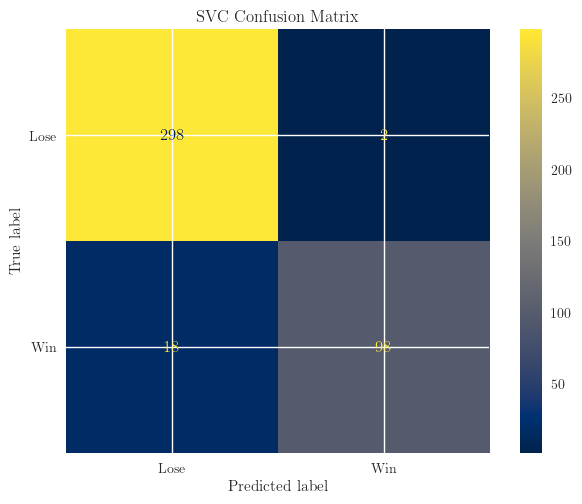

In [63]:
cm_svc = confusion_matrix(y_test, svc.predict(X_test_mm), labels=svc.classes_)

ConfusionMatrixDisplay(confusion_matrix=cm_svc, display_labels=['Lose','Win']).plot(cmap=plt.cm.cividis)

plt.title('SVC Confusion Matrix')

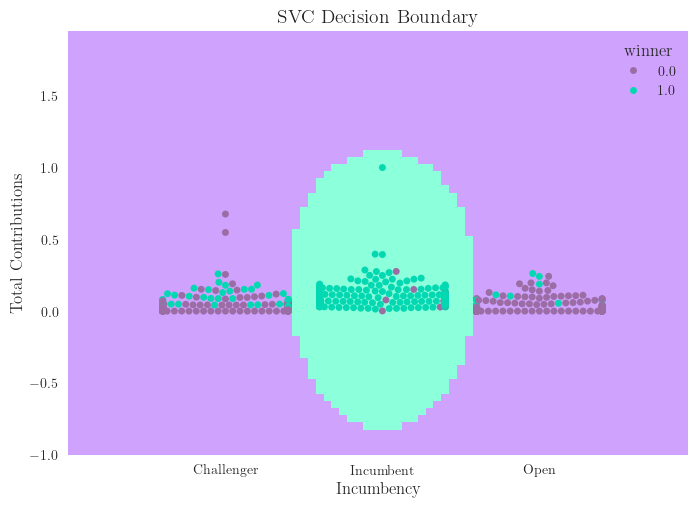

In [64]:
H = house.copy(deep=True)

H['inc'] = H['inc'].map({'Incumbent':1,'Challenger':2,'Open':0})

H['tot_rec'] = ( H['tot_rec'] - min(H['tot_rec']) ) / ( max(H['tot_rec']) - min(H['tot_rec']) )

X = H[['inc','tot_rec']]

y = H['winner']

h = .05  

cmap_light = ListedColormap(['#cea2fd','#8cffdb'])
cmap_bold = ListedColormap(['#9c6da5','#04d8b2'])

clf = svc
clf.fit(X, y)

x_min, x_max = X['inc'].min() - 1, X['inc'].max() + 1
y_min, y_max = X['tot_rec'].min() - 1, X['tot_rec'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

sns.swarmplot(data=H, x='inc', y='tot_rec', hue='winner', palette=['#9c6da5','#04d8b2'])
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("SVC Decision Boundary", fontsize=14)
plt.xticks(ticks=[0,1,2], labels=['Challenger','Incumbent','Open'])
plt.xlabel('Incumbency', fontsize=12)
plt.ylabel('Total Contributions', fontsize=12)
plt.savefig('../../results/larger-dataset/figures/svc_decision_boundary.png')
plt.show()


#### Decision Tree

In [65]:
tree_grid = {'criterion':['gini','entropy','log_loss'], 'max_depth':range(2,10), 'ccp_alpha': [0.1,0.01,0.001,0]}

tree = optimizer(DecisionTreeClassifier(), tree_grid, X_train_mm, y_train)

tree.fit(X_train_mm, y_train)

DecisionTreeClassifier(ccp_alpha=0.001, criterion='entropy', max_depth=4)

In [66]:
print(classification_report(tree.predict(X_test_mm), y_test))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       304
           1       0.90      0.93      0.91       112

    accuracy                           0.95       416
   macro avg       0.93      0.94      0.94       416
weighted avg       0.95      0.95      0.95       416



Text(0.5, 1.0, 'Decision Tree Confusion Matrix')

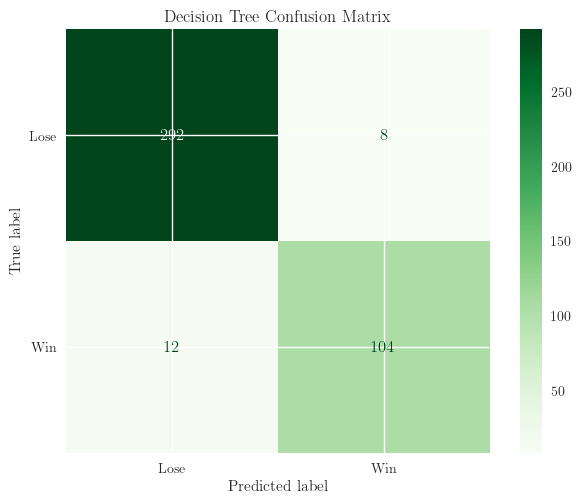

In [67]:
cm_tree = confusion_matrix(y_test, tree.predict(X_test_mm), labels=tree.classes_)

ConfusionMatrixDisplay(confusion_matrix=cm_tree, display_labels=['Lose','Win']).plot(cmap=plt.cm.Greens)

plt.title('Decision Tree Confusion Matrix')

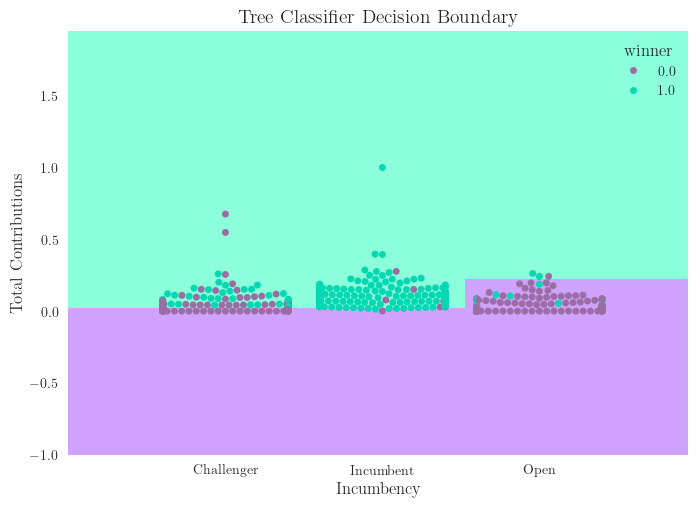

In [68]:
H = house.copy(deep=True)

H['inc'] = H['inc'].map({'Incumbent':1,'Challenger':2,'Open':0})

H['tot_rec'] = ( H['tot_rec'] - min(H['tot_rec']) ) / ( max(H['tot_rec']) - min(H['tot_rec']) )

X = H[['inc','tot_rec']]

y = H['winner']

h = .05  

cmap_light = ListedColormap(['#cea2fd','#8cffdb'])
cmap_bold = ListedColormap(['#9c6da5','#04d8b2'])

clf = tree
clf.fit(X, y)

x_min, x_max = X['inc'].min() - 1, X['inc'].max() + 1
y_min, y_max = X['tot_rec'].min() - 1, X['tot_rec'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

sns.swarmplot(data=H, x='inc', y='tot_rec', hue='winner', palette=['#9c6da5','#04d8b2'])
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("Tree Classifier Decision Boundary", fontsize=14)
plt.xticks(ticks=[0,1,2], labels=['Challenger','Incumbent','Open'])
plt.xlabel('Incumbency', fontsize=12)
plt.ylabel('Total Contributions', fontsize=12)
plt.savefig('../../results/larger-dataset/figures/tree_classifier_decision_boundary.png')
plt.show()


## Multilayer Perceptron

In [69]:
mlp_grid = {'hidden_layer_sizes':[(j,j,j) for j in range(10,30,10)], 'activation':['indentity','logistic','tanh','relu'], 
            'solver':['lbfgs','sgd','adam']}

mlp = optimizer(MLPClassifier(random_state=137), mlp_grid, X_train_mm, y_train)

mlp.fit(X_train_mm, y_train)

MLPClassifier(hidden_layer_sizes=(20, 20, 20), random_state=137, solver='lbfgs')

In [70]:
print(classification_report(mlp.predict(X_test_mm), y_test))

report_dict = classification_report(y_test, mlp.predict(X_test_mm), output_dict=True)

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       305
           1       0.89      0.93      0.91       111

    accuracy                           0.95       416
   macro avg       0.93      0.94      0.94       416
weighted avg       0.95      0.95      0.95       416



Text(0.5, 1.0, 'Triple-Layer Perceptron Confusion Matrix')

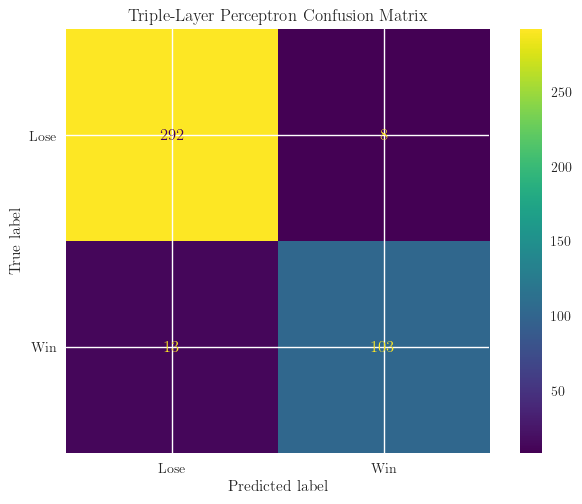

In [71]:
cm_mlp = confusion_matrix(y_test, mlp.predict(X_test_mm), labels=mlp.classes_)

ConfusionMatrixDisplay(confusion_matrix=cm_mlp, display_labels=['Lose','Win']).plot(cmap=plt.cm.viridis)

plt.title('Triple-Layer Perceptron Confusion Matrix')

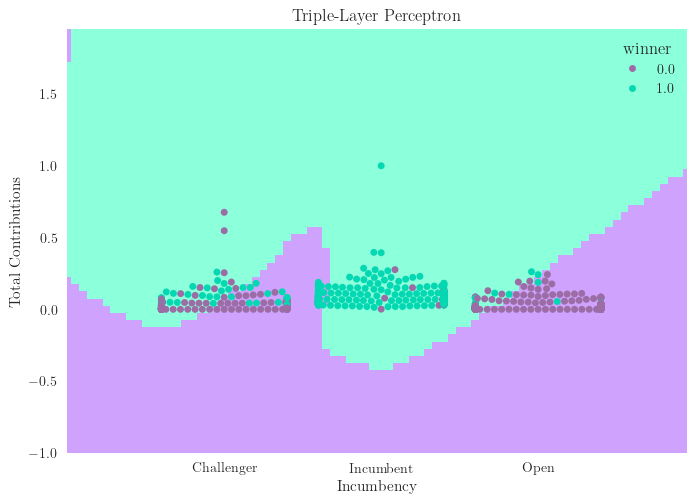

In [72]:
H = house.copy(deep=True)

H['inc'] = H['inc'].map({'Incumbent':1,'Challenger':2,'Open':0})

H['tot_rec'] = ( H['tot_rec'] - min(H['tot_rec']) ) / ( max(H['tot_rec']) - min(H['tot_rec']) )

X = H[['inc','tot_rec']]

y = H['winner']

h = .05  

cmap_light = ListedColormap(['#cea2fd','#8cffdb'])
cmap_bold = ListedColormap(['#9c6da5','#04d8b2'])

clf = MLPClassifier(hidden_layer_sizes=(10,10,10), activation='logistic', solver='lbfgs', random_state=137)
clf.fit(X, y)

x_min, x_max = X['inc'].min() - 1, X['inc'].max() + 1
y_min, y_max = X['tot_rec'].min() - 1, X['tot_rec'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

sns.swarmplot(data=H, x='inc', y='tot_rec', hue='winner', palette=['#9c6da5','#04d8b2'])
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title('Triple-Layer Perceptron')
plt.xticks(ticks=[0,1,2], labels=['Challenger','Incumbent','Open'])
plt.xlabel('Incumbency')
plt.ylabel('Total Contributions')
plt.savefig('../../results/larger-dataset/figures/perceptron_decision_boundary.png')
plt.show()